In [1]:
import os

import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
import phate

In [3]:
os.chdir('..')
import manifold_methods
import plotting
import mappings
import data_loader

In [4]:
exp_path = '/lustre06/project/6065672/shared/DietNet/1KGB_POP24/1KGP/WGS30X_V1/oldnow/MattsPlace'
fname = '1000G.2504_WGS30x.GSA17k_MHI.intersectGSA.miss10perc.maf0.05.pruned.autosomes.noHLA.phased_imputed_V1.hdf5'

In [5]:
with h5py.File(os.path.join(exp_path, fname), 'r') as hf:
    #model_attrs = hf['gradients'][:]
    #print('loaded gradient of fc1 w.r.t. input from {}'.format(attr_fc1_saliency_name))
    inputs = hf['inputs'][:]
    class_label_names = hf['class_label_names'][:]
    class_labels = hf['class_labels'][:]
    samples = hf['samples'][:]
    snp_names = hf['snp_names'][:]

In [6]:
label_with_names = [str(class_label_names[y])[2:-1] for y in class_labels]

In [7]:
label_with_superpop_names = np.zeros_like(label_with_names)
for label in mappings.super_pops_1000G:
    index = pd.DataFrame(label_with_names).isin(mappings.super_pops_1000G[label]).values.flatten()
    label_with_superpop_names[index] = label

In [8]:
def plot_embeddings_1000G_labels(emb, labels, palette, label_order, ax):
    
    sns.scatterplot(x=emb[:,0],
                    y=emb[:,1],
                    ax=ax,
                    palette=palette,
                    hue_order=label_order,
                    hue=pd.Categorical(labels))
    ax.legend(bbox_to_anchor=(1.1, 1.05), loc='upper left')

    for label in np.unique(labels):
        index = label == labels
        mean_pos = emb[index,:2].mean(0)
        ax.text(x=mean_pos[0], 
                y=mean_pos[1], 
                s=label)

In [9]:
import sklearn
pca_obj = sklearn.decomposition.PCA(n_components=100, random_state=42)
pca_input = pca_obj.fit_transform(inputs)

In [11]:
pca_input.shape

(2322, 100)

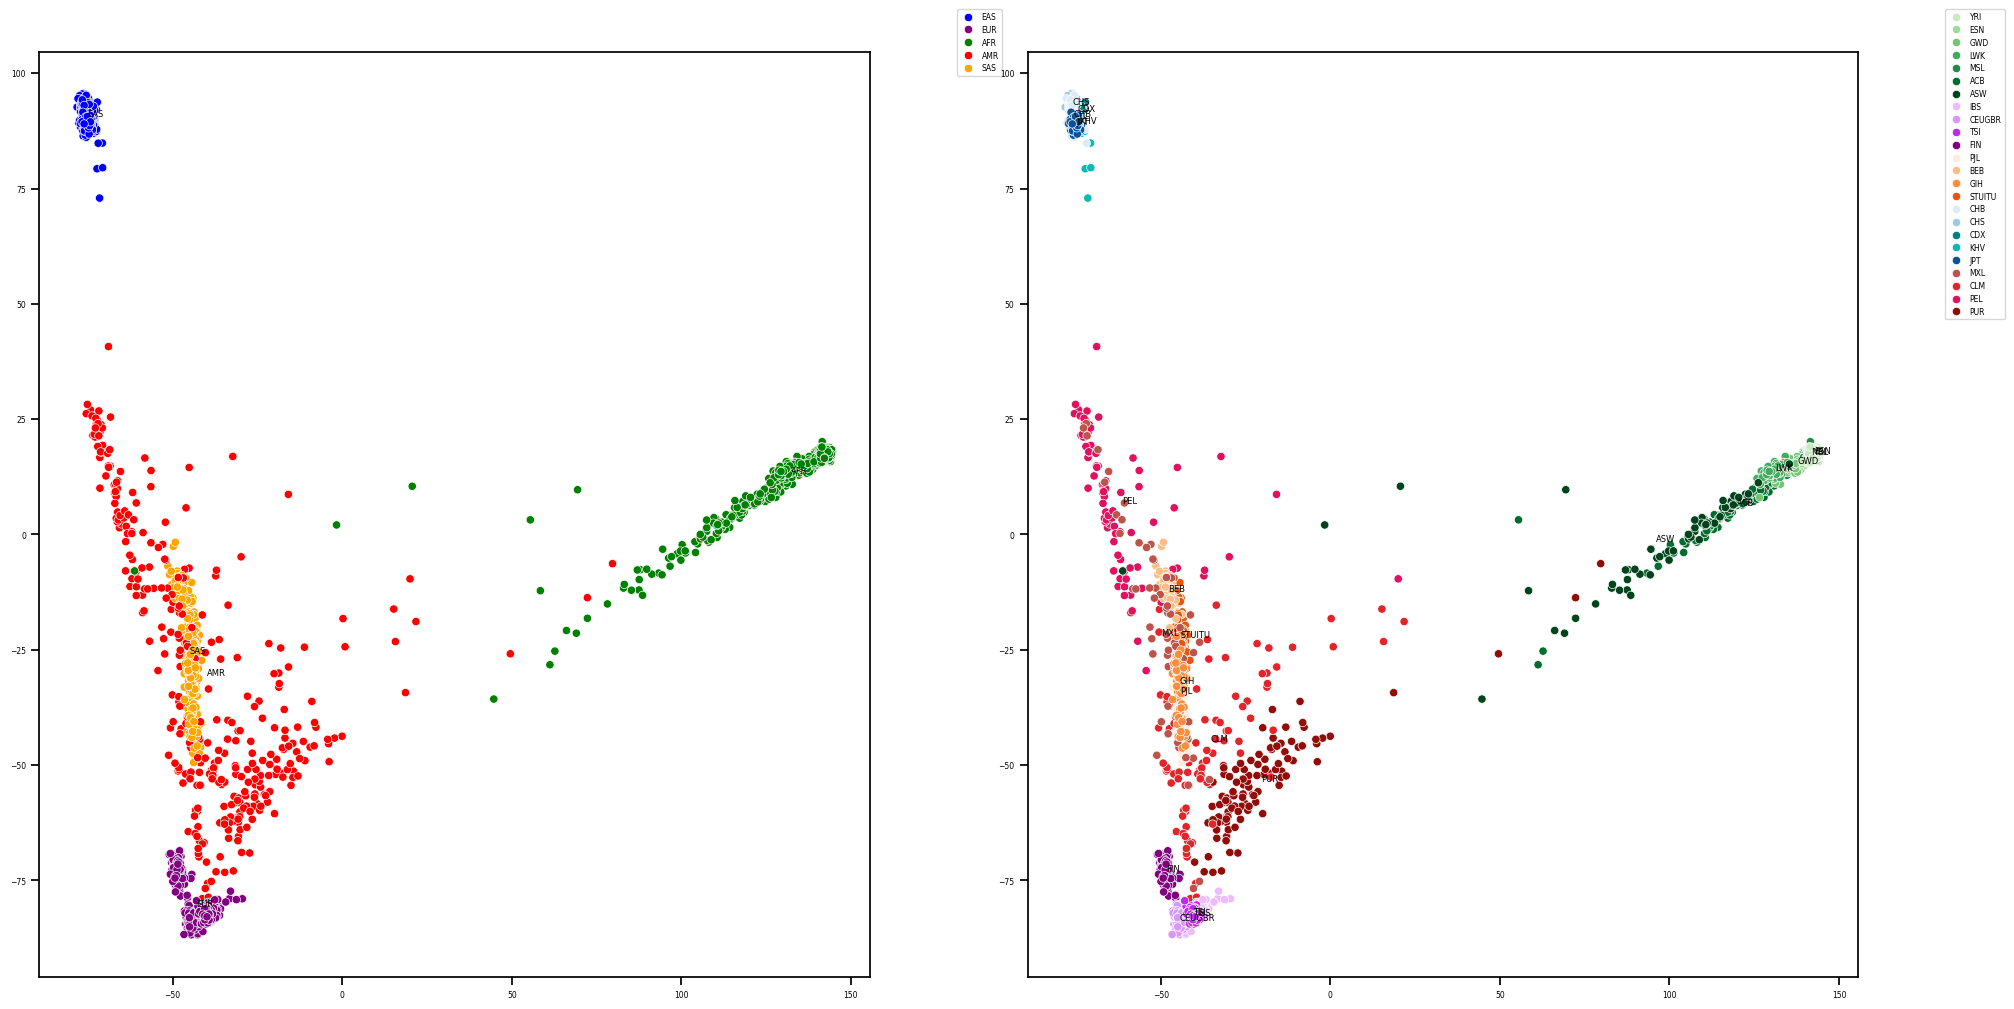

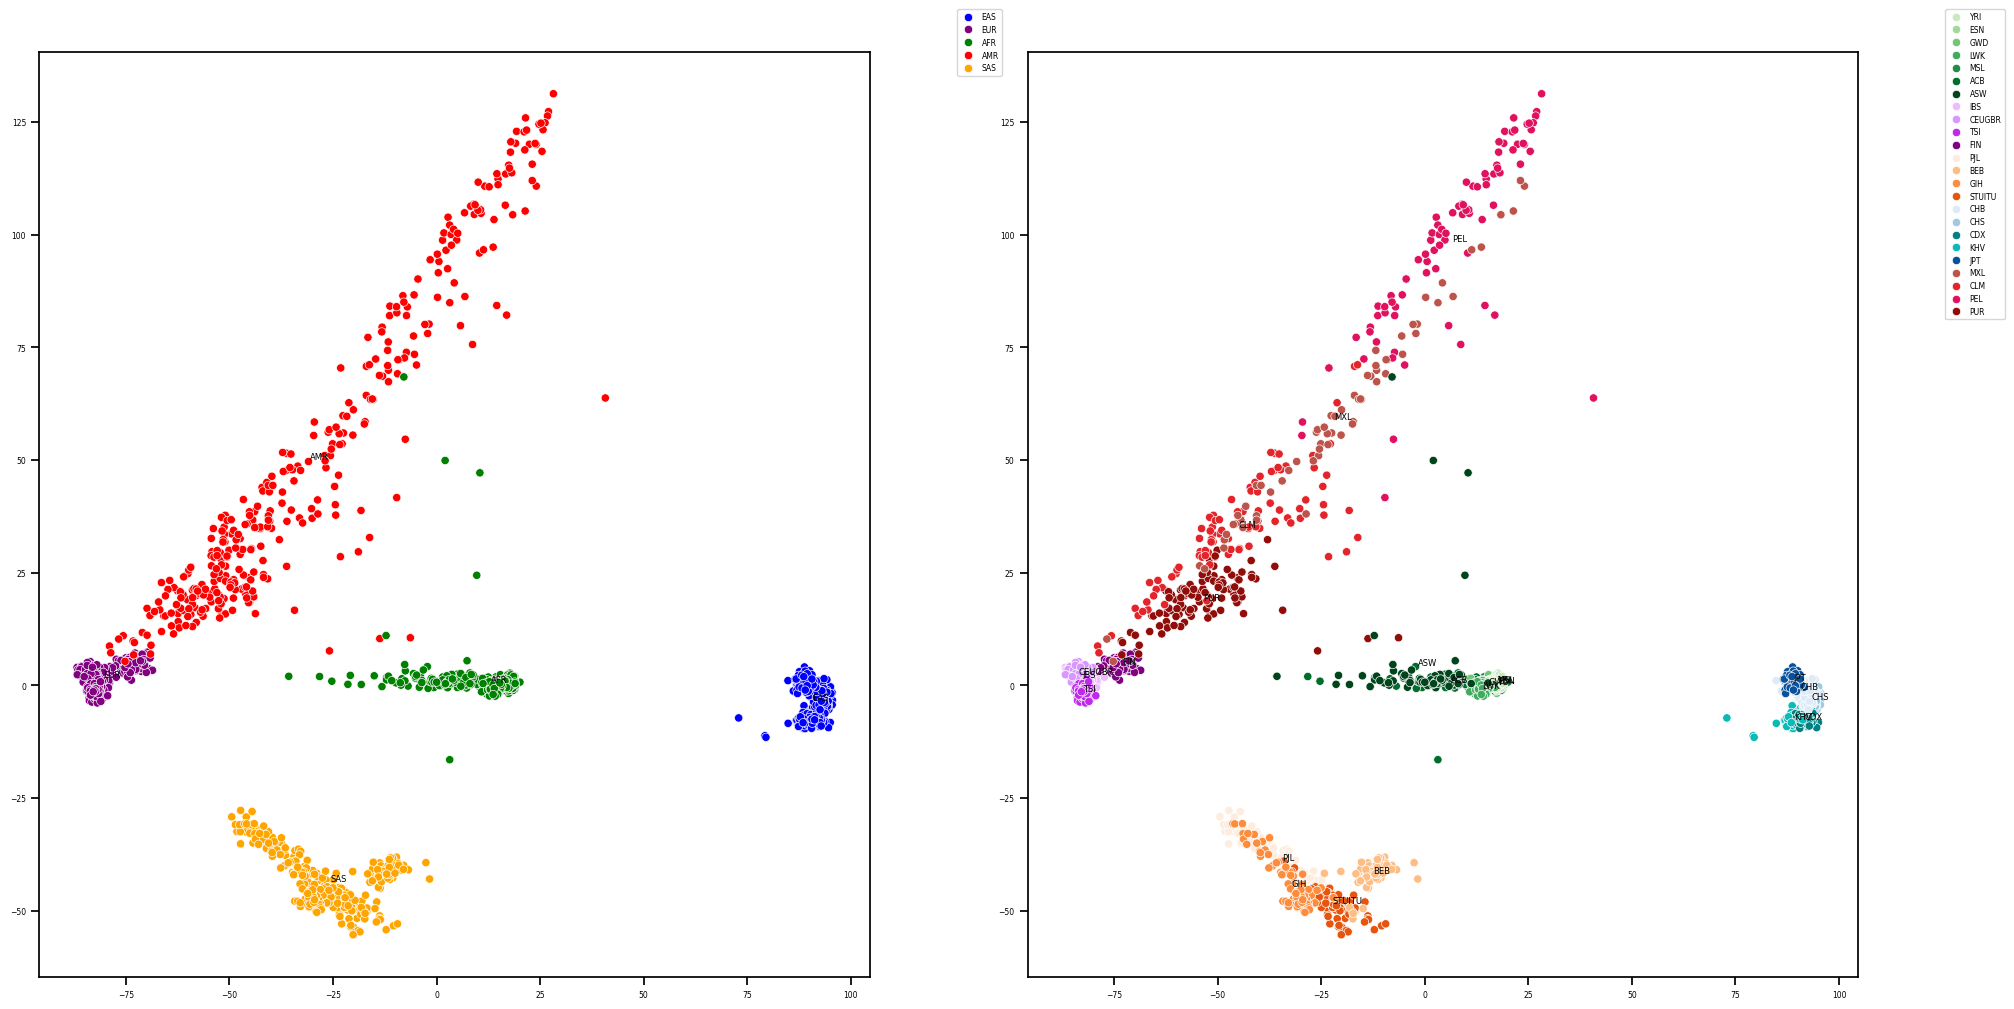

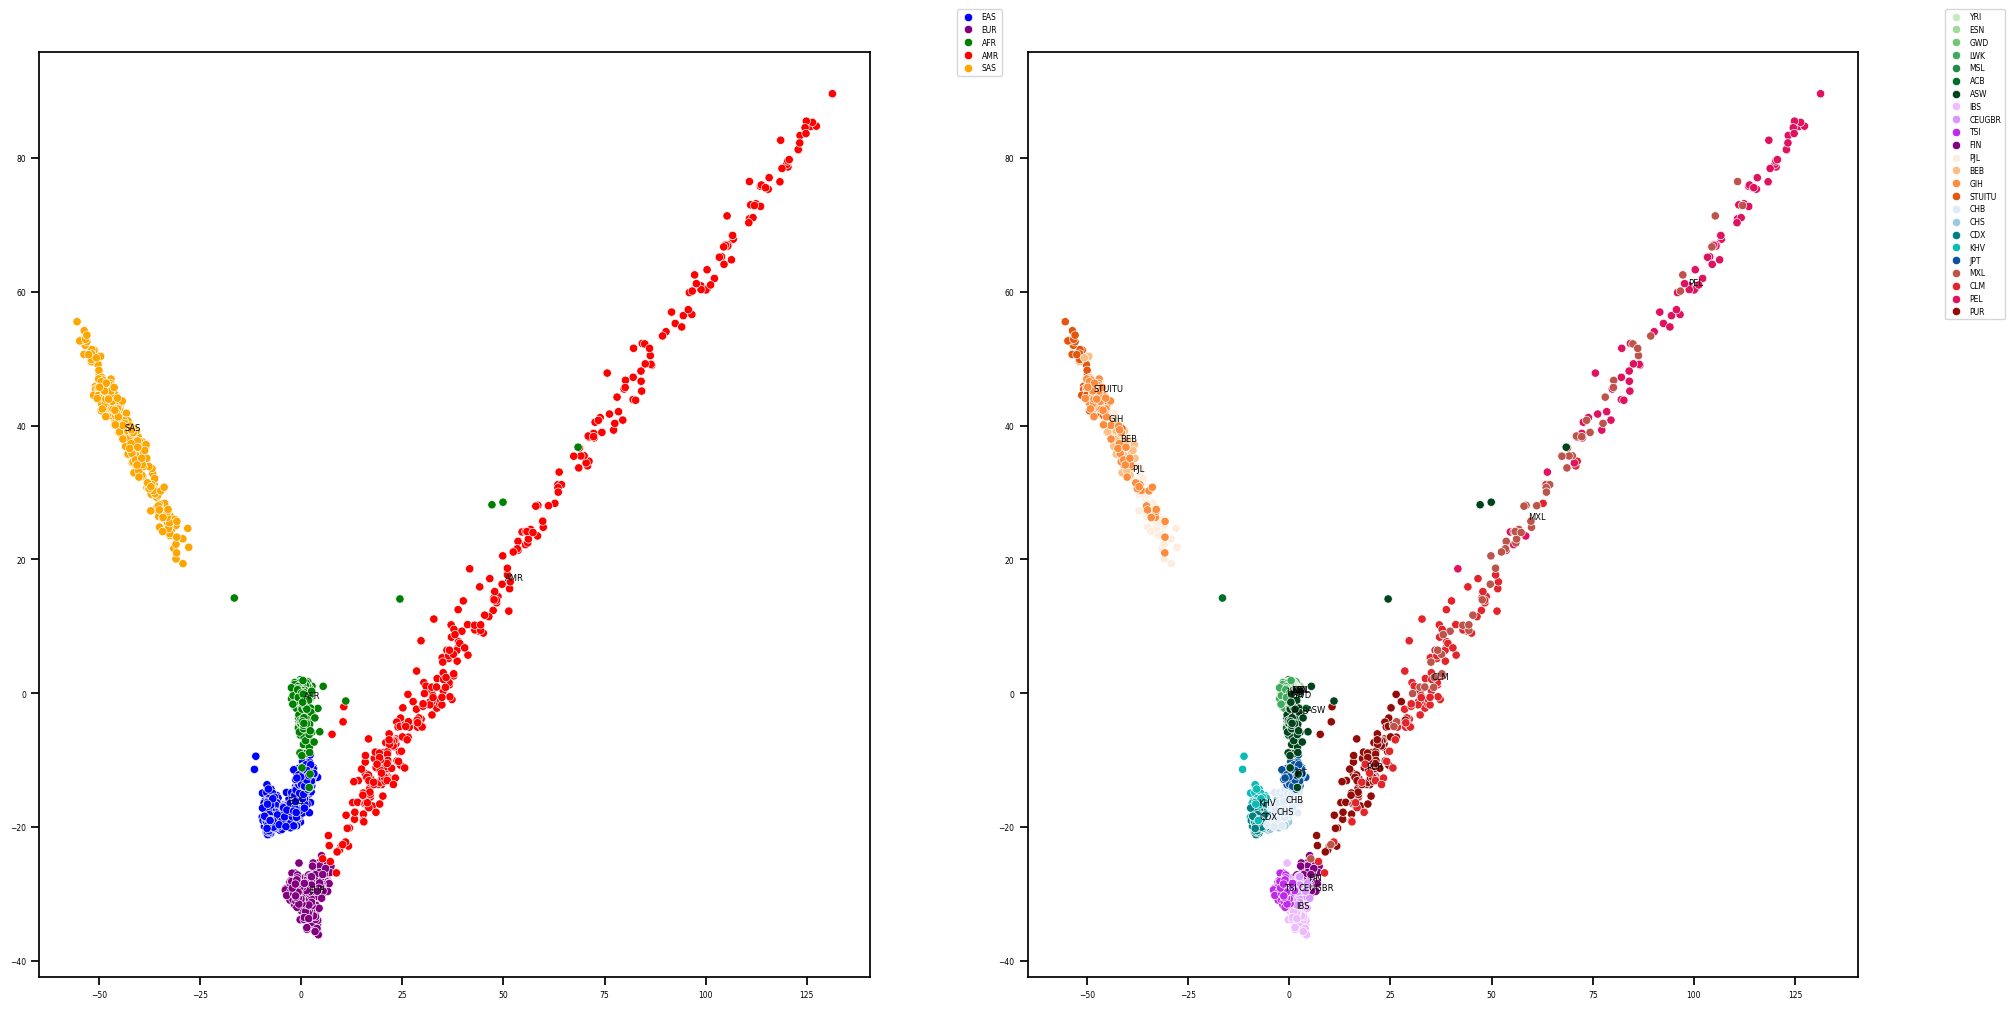

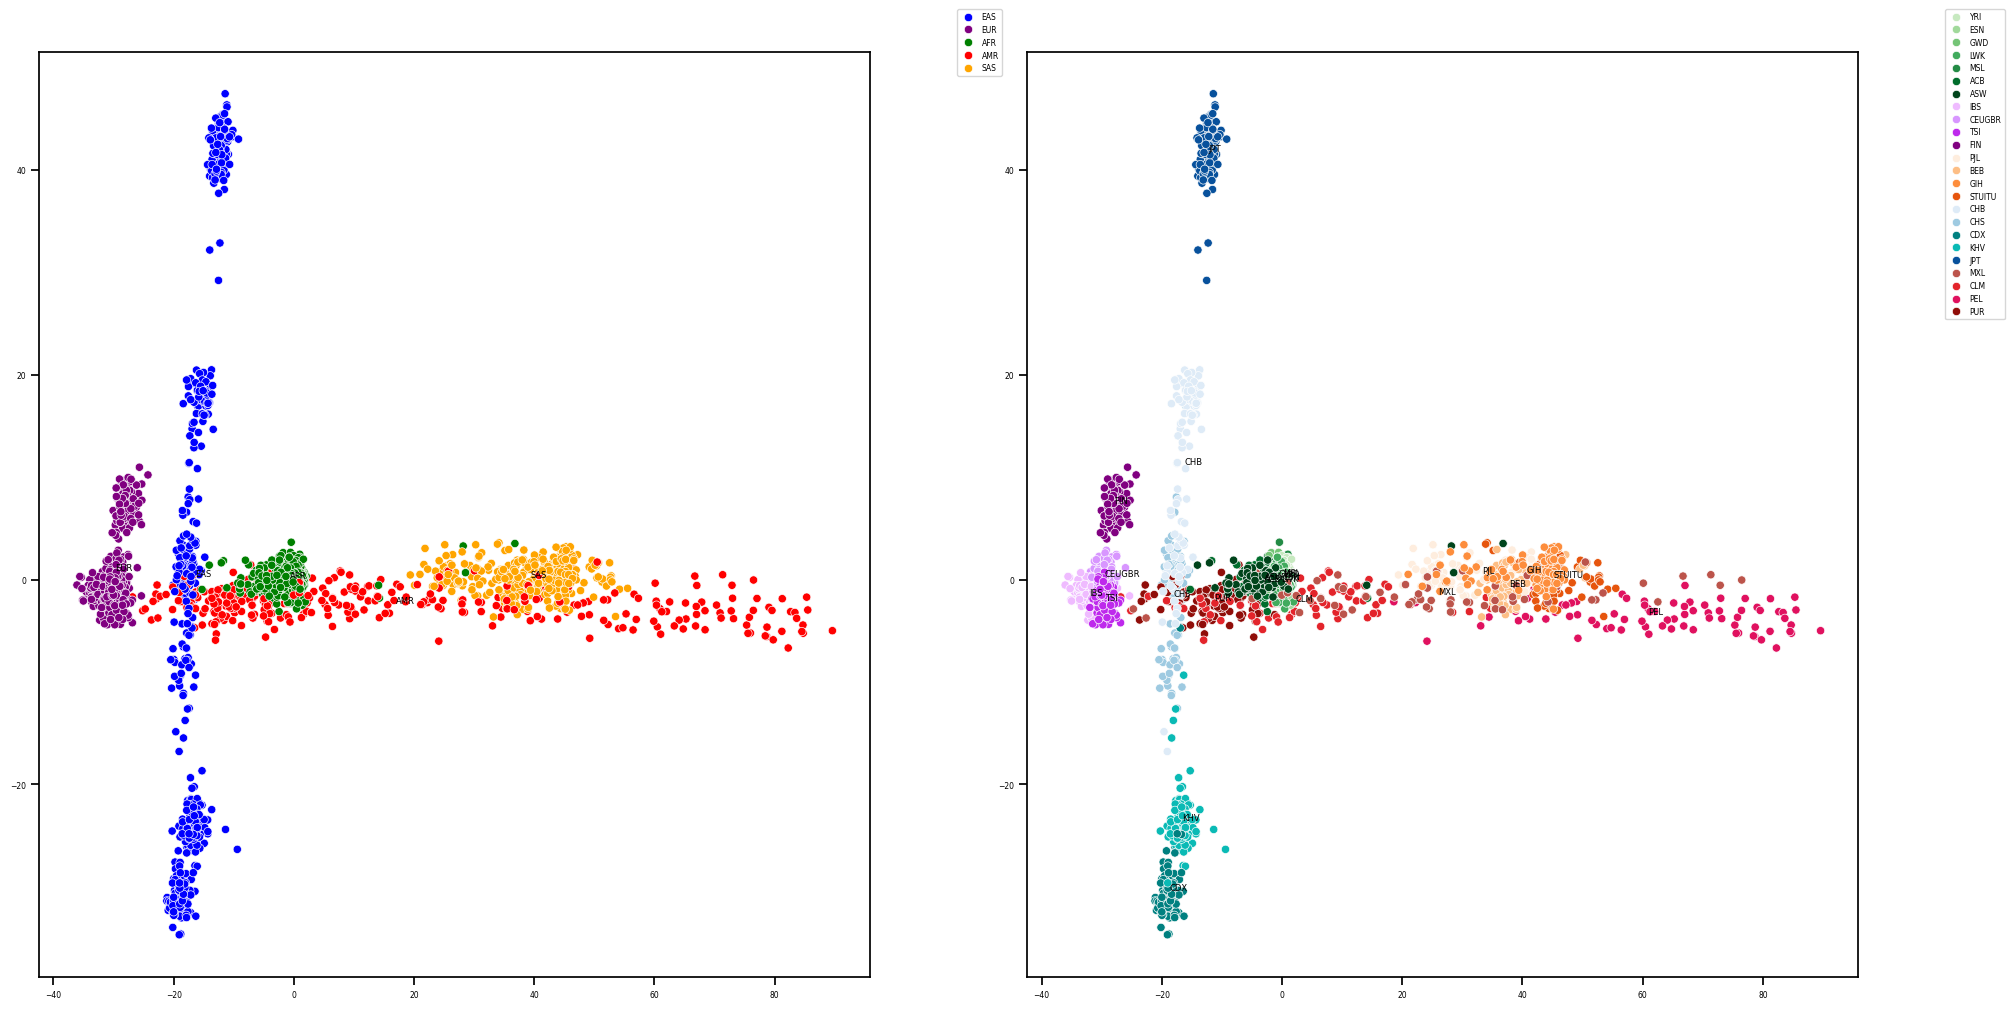

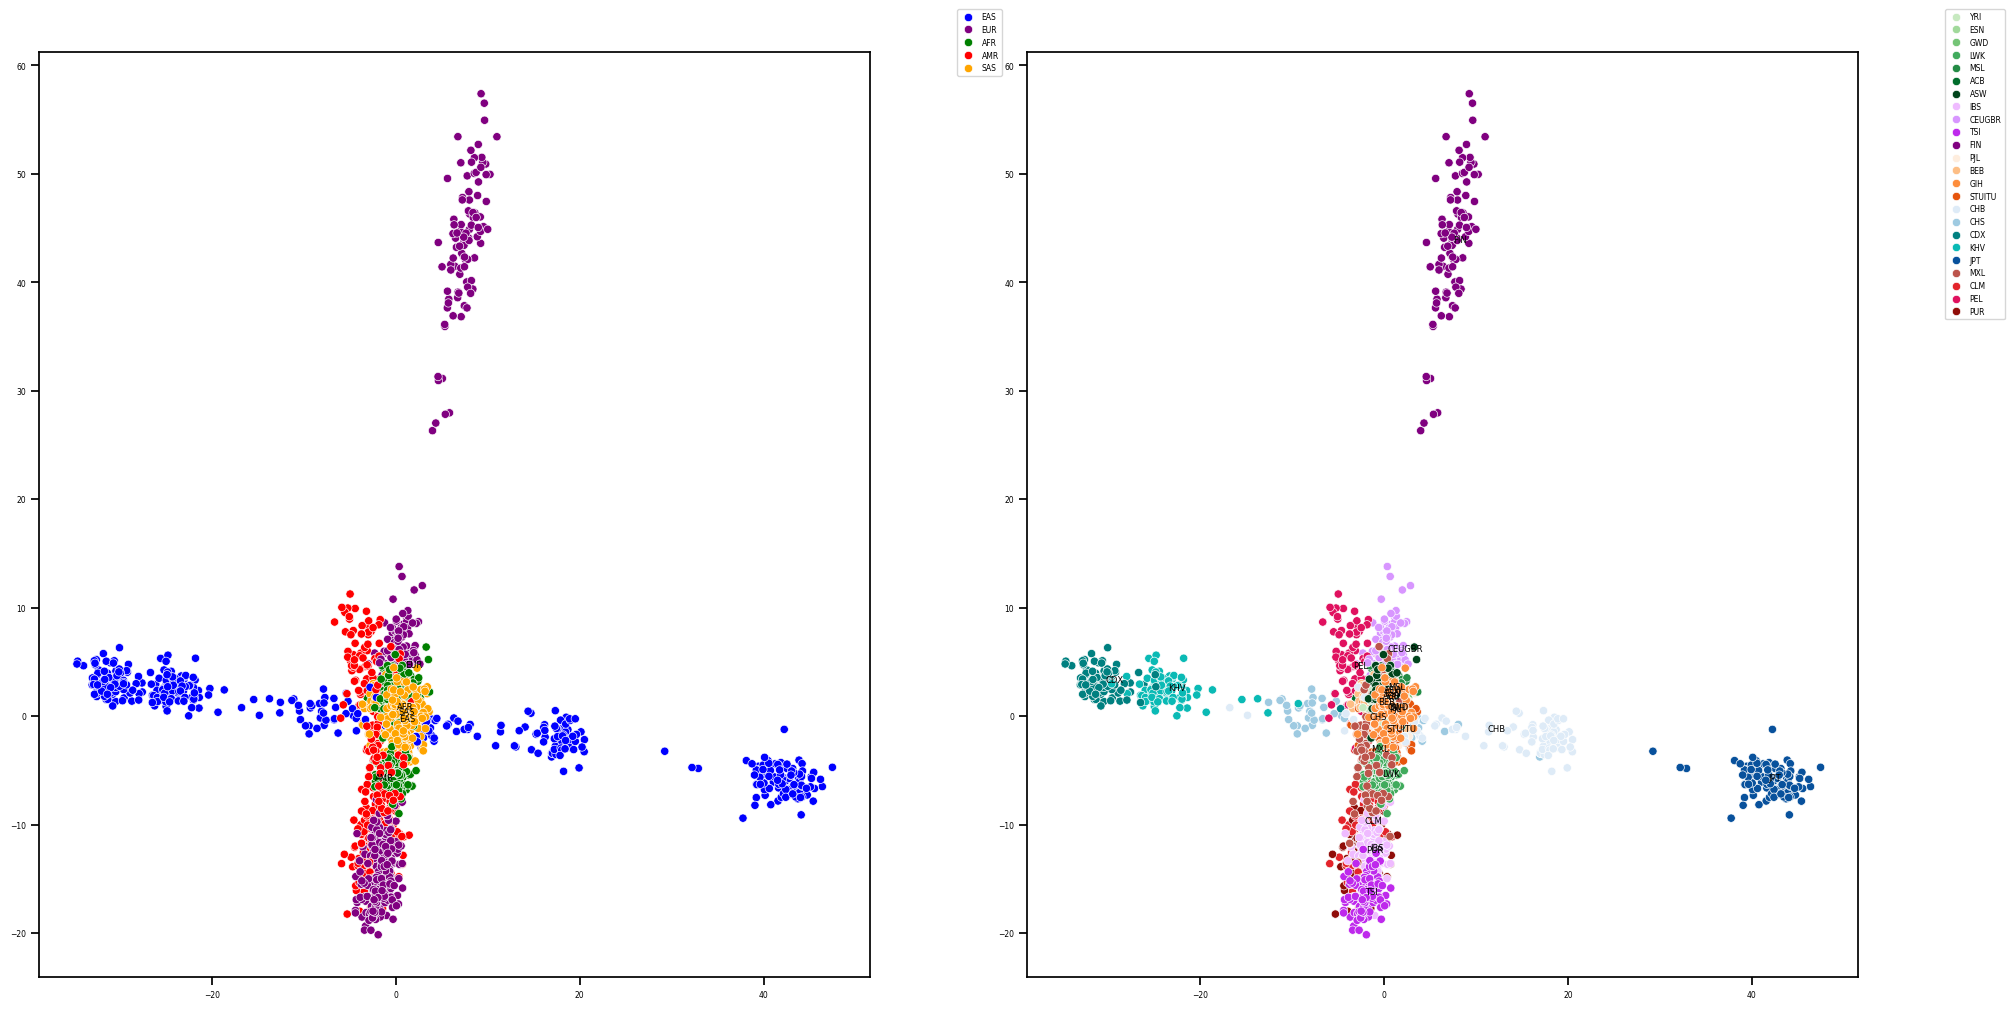

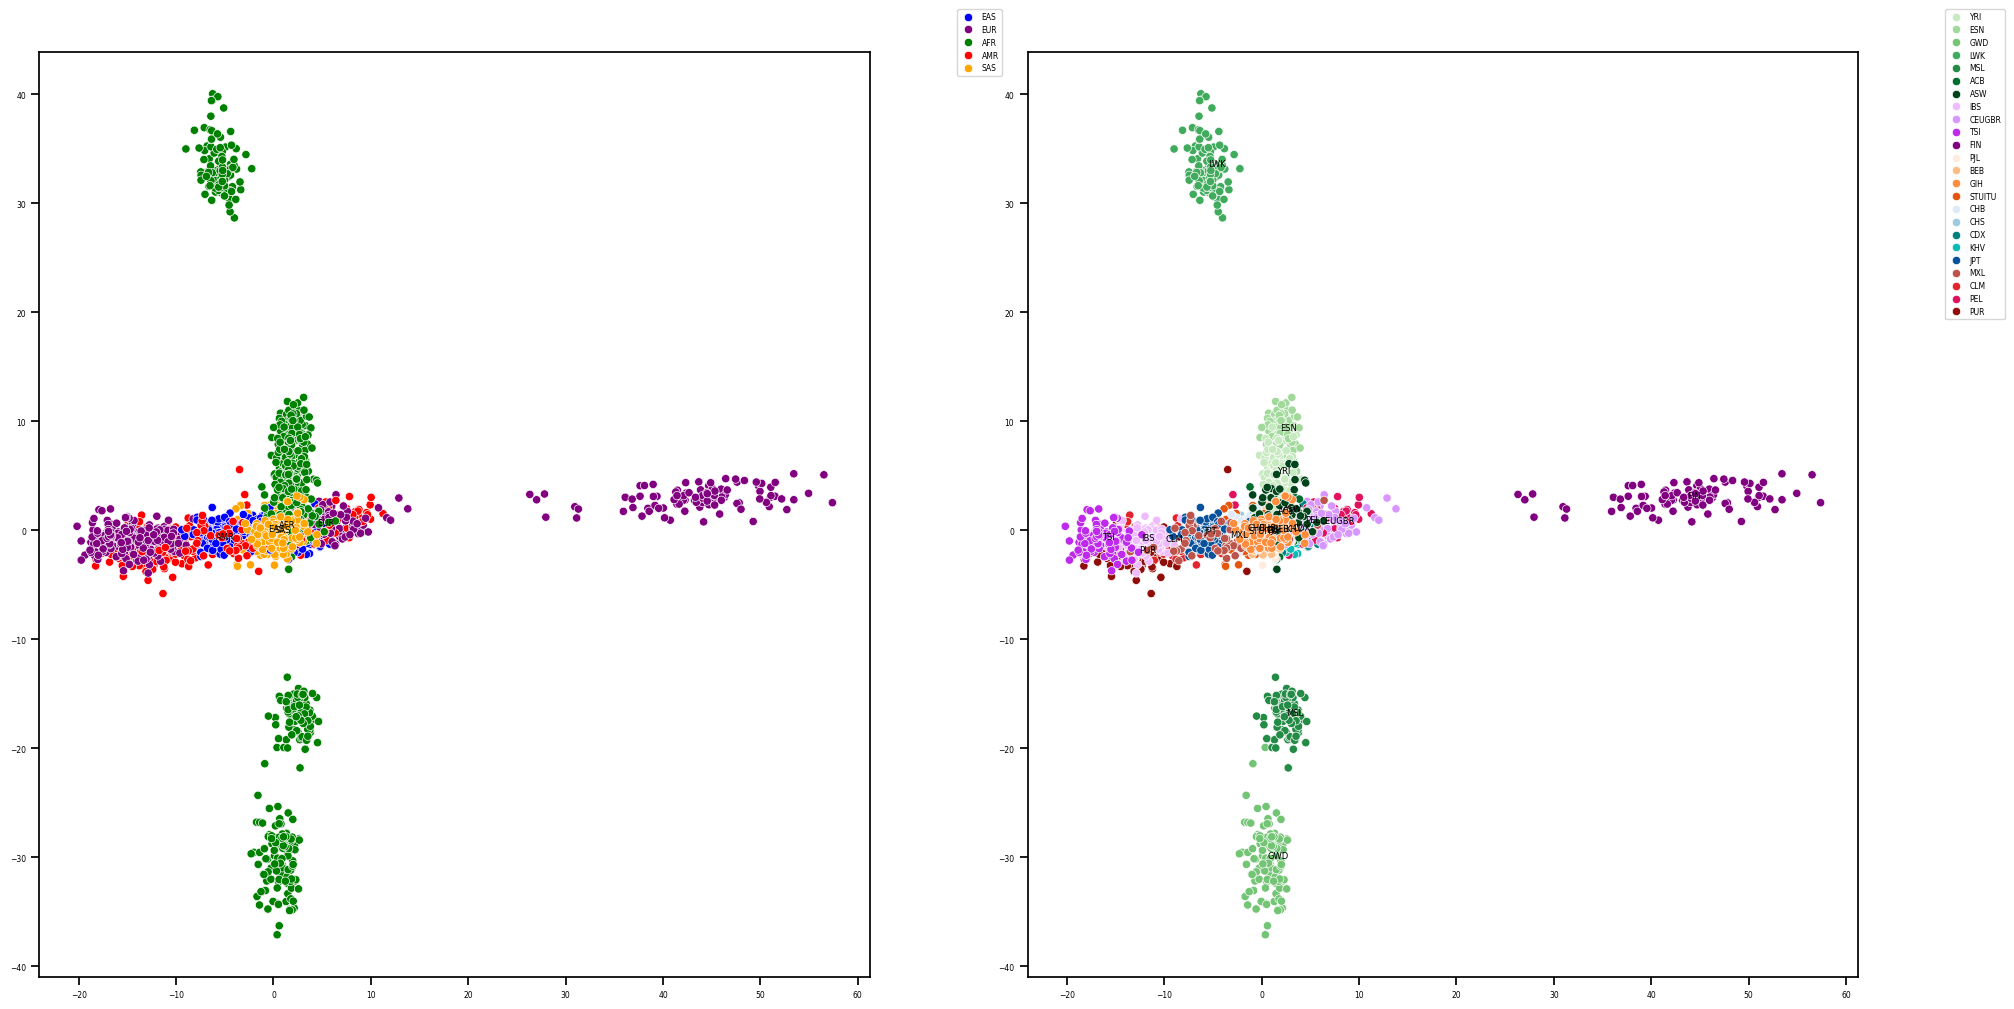

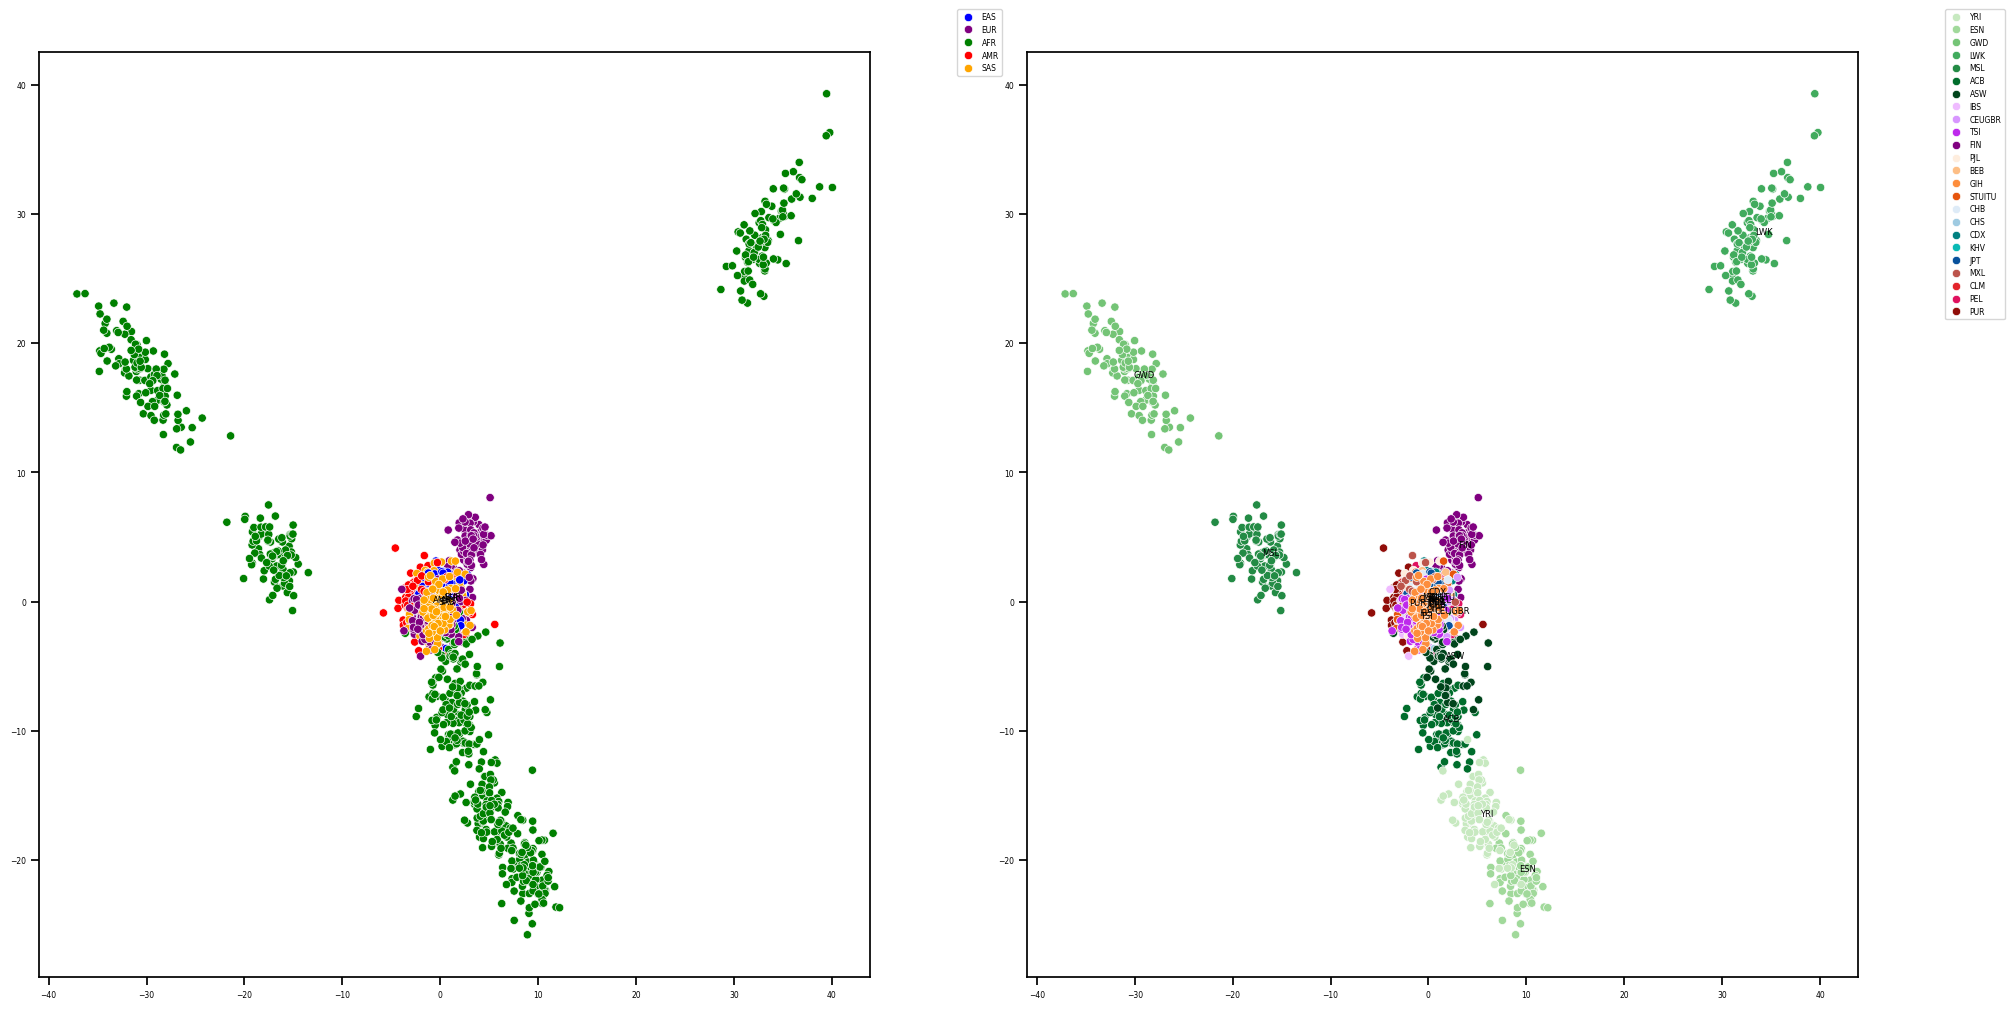

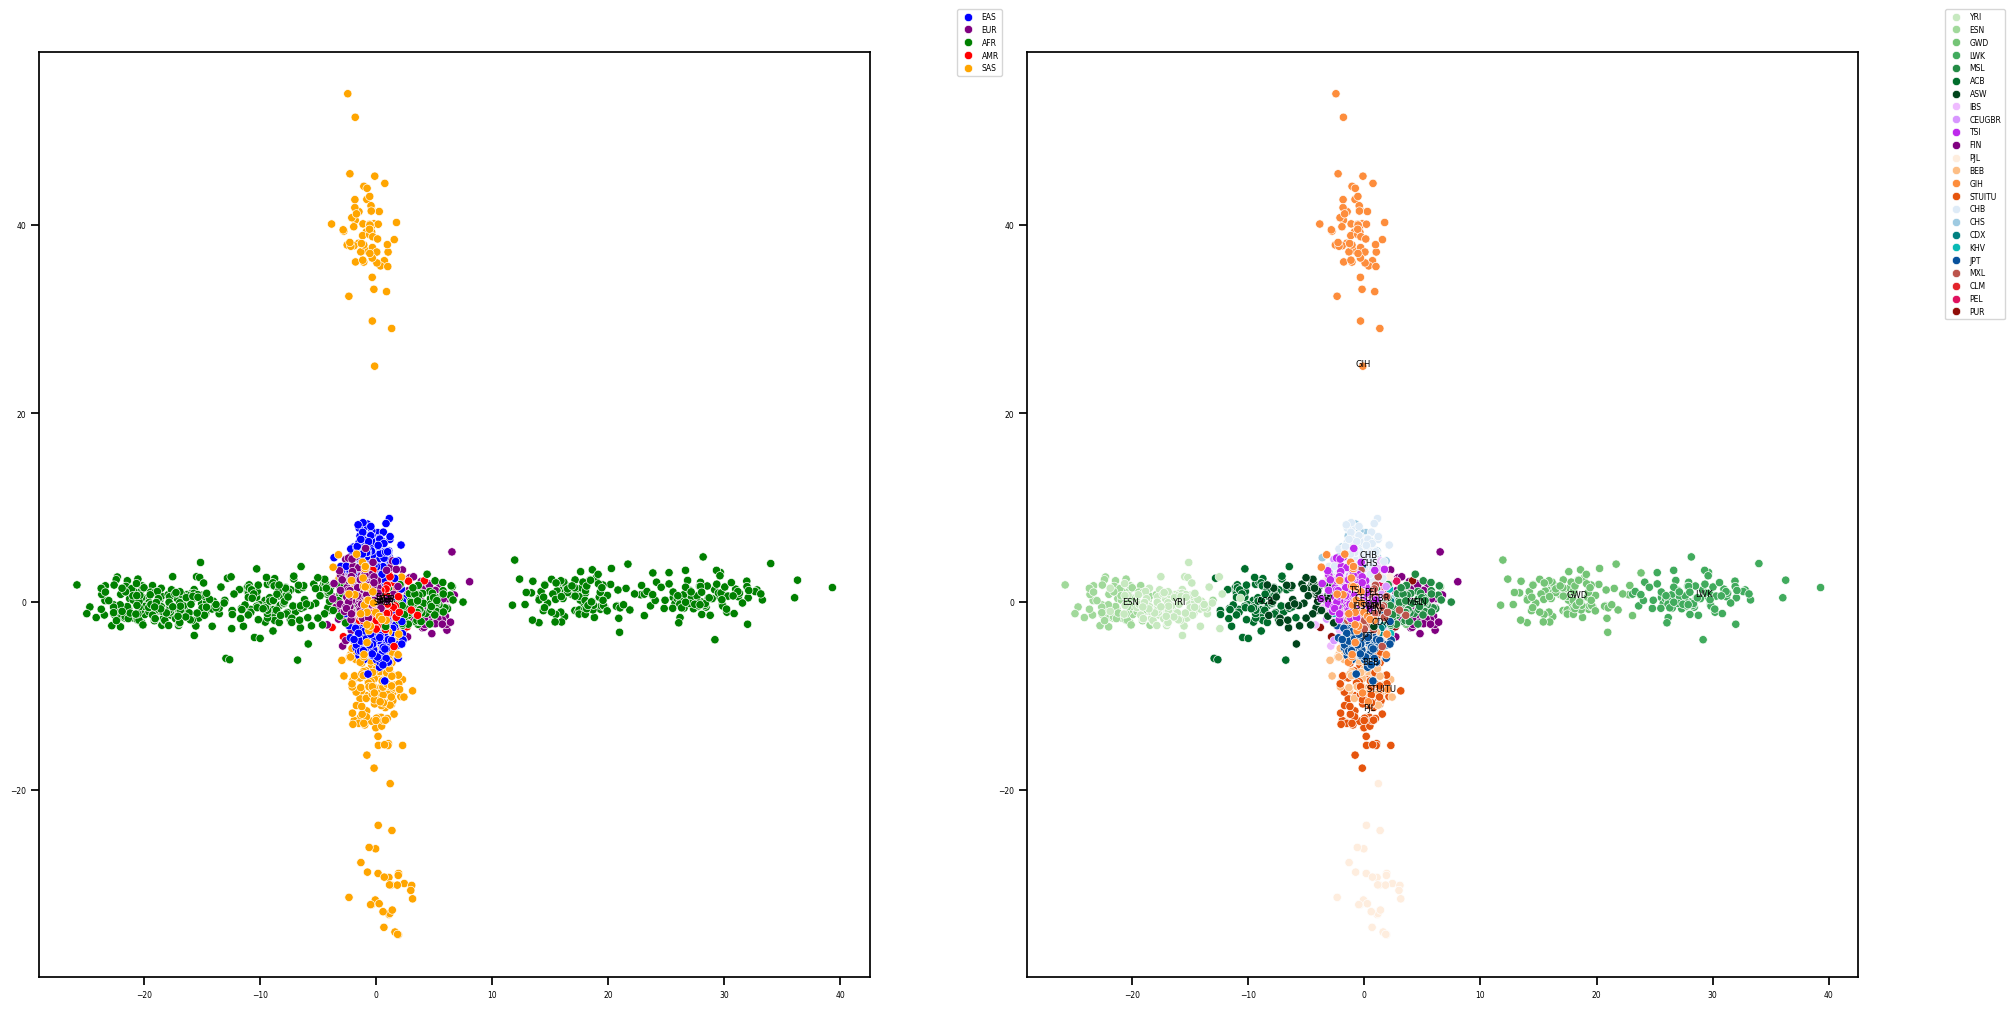

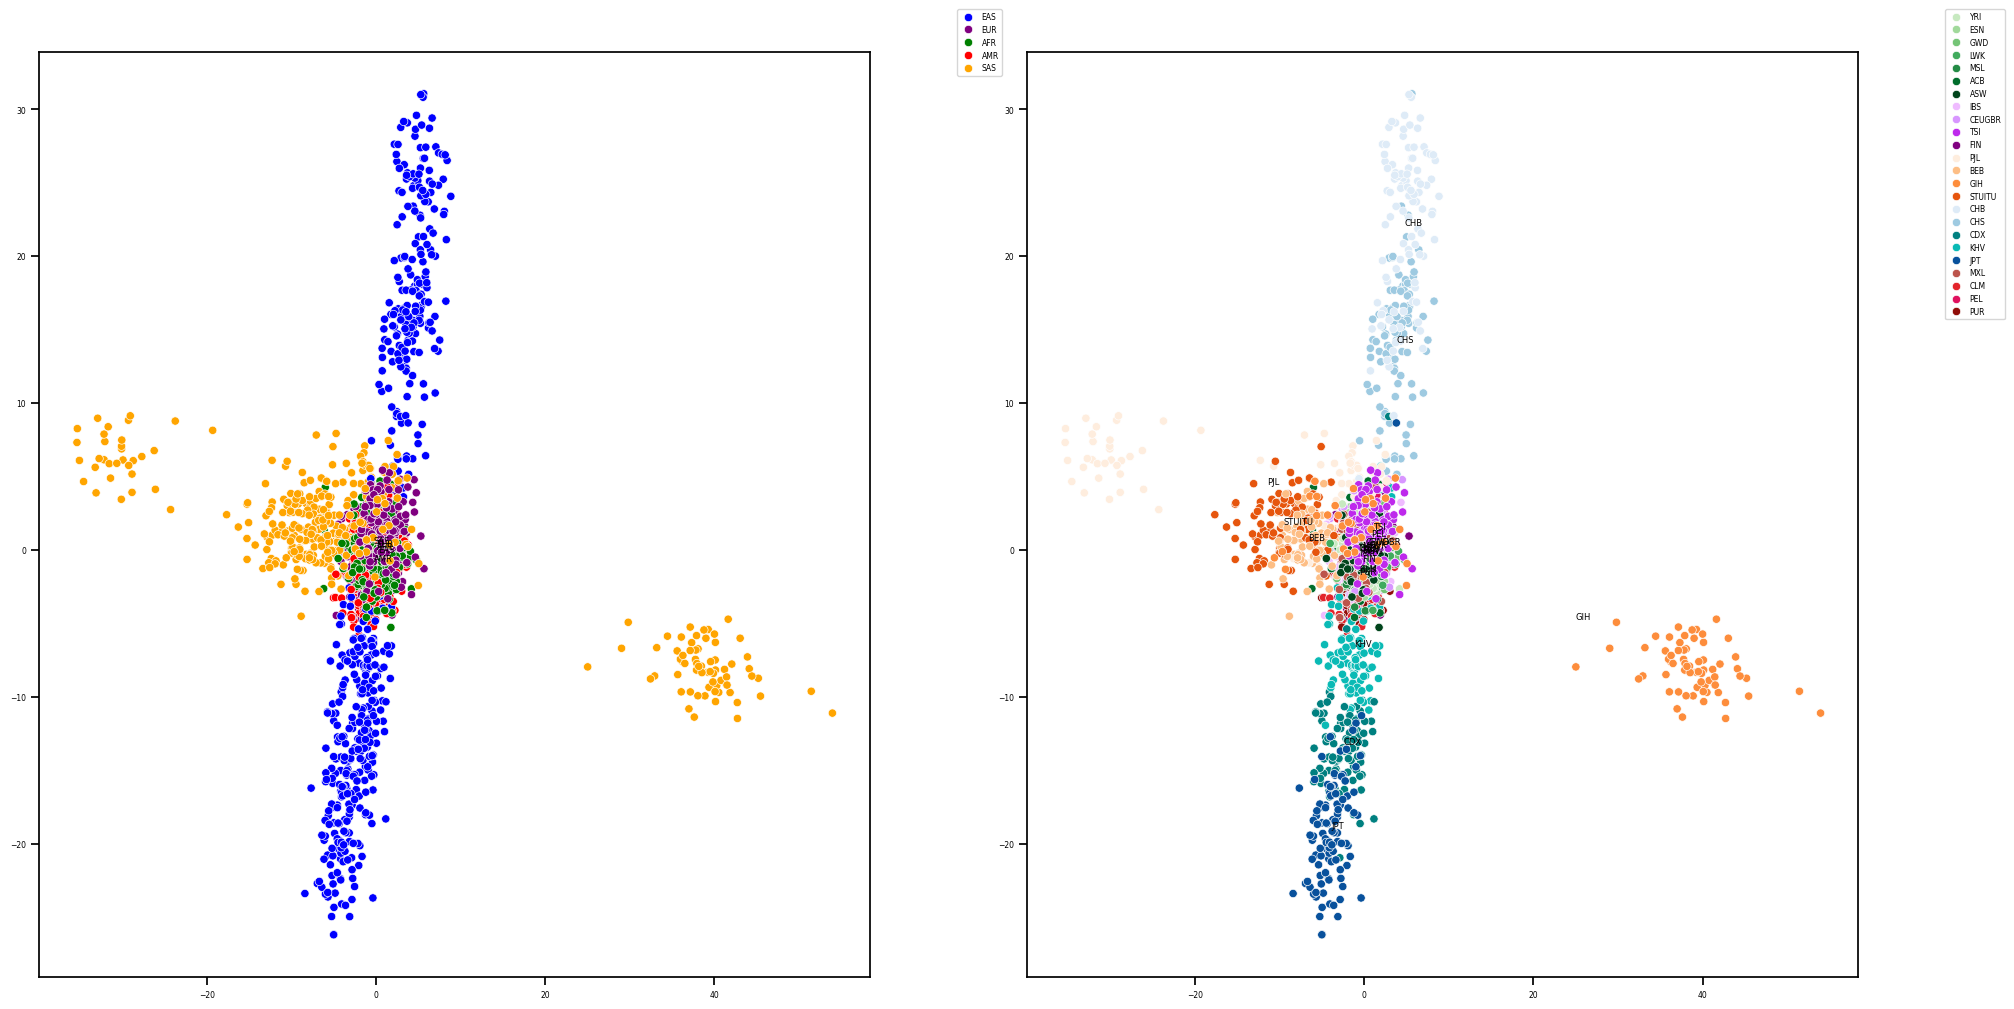

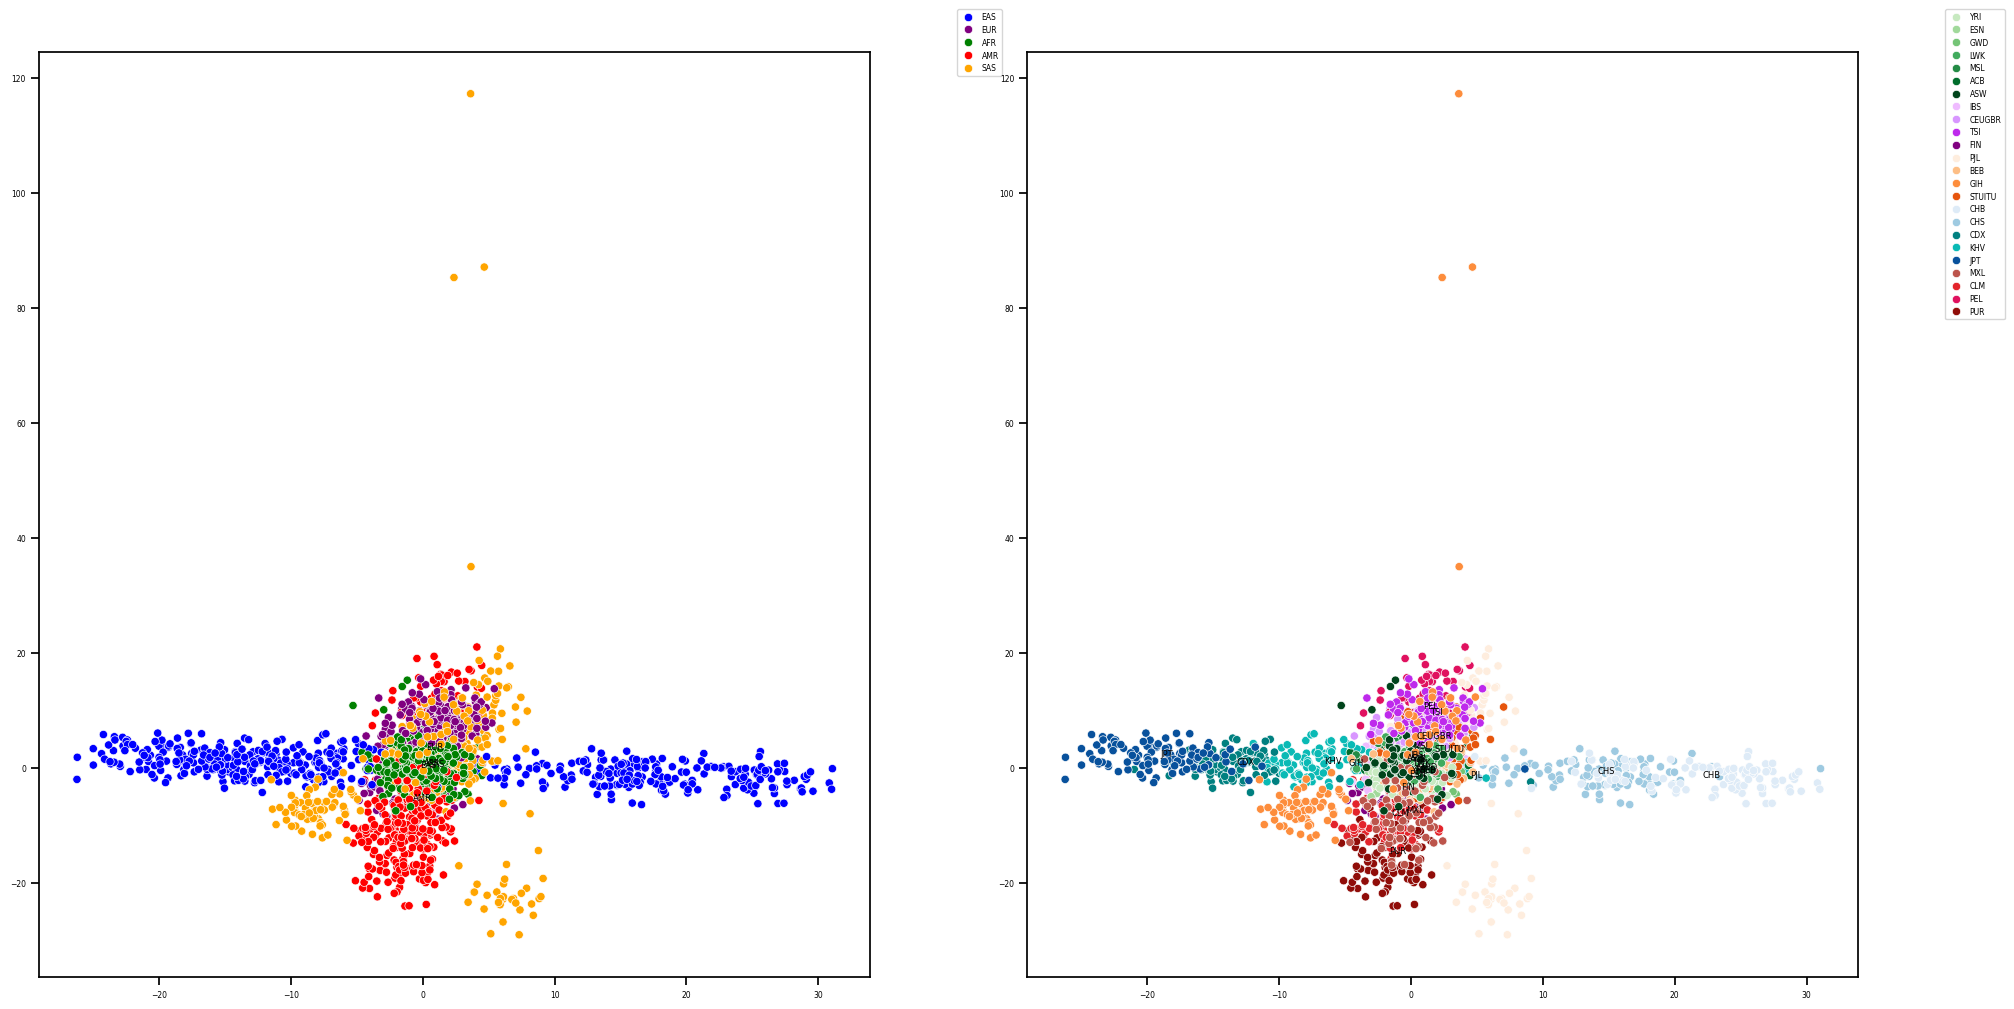

In [13]:
for comp in range(10):
# initial 2D phate embedding
    fig, ax = plt.subplots(ncols=2, figsize=(20,10))
    plot_embeddings_1000G_labels(pca_input[:,comp:(comp+2)], 
                                 np.array(label_with_superpop_names), 
                                 mappings.pop_pallette_1000G_coarse,
                                 mappings.label_order_1000G_coarse,
                                 ax[0])
    plot_embeddings_1000G_labels(pca_input[:,comp:(comp+2)], 
                                 np.array(label_with_names),
                                 mappings.pop_pallette_1000G_fine,
                                 mappings.label_order_1000G_fine,
                                 ax[1])
    plt.tight_layout()

## Admix Ratios

In [15]:
sample_ids = pd.read_csv('notebooks/MyAdmix/output_ids.txt', sep=' ', header=None)
admix_ratios = pd.read_csv('notebooks/MyAdmix/AMR_ACB_ASW.3.Q', sep=' ', header=None)

admix_labels_custom = np.zeros([len(label_with_names), 3])
admix_df = pd.concat([admix_ratios, sample_ids], axis=1)
admix_df.columns = ['admix 1', 'admix 2', 'admix 3' , 'sample id']

labels2 = np.array([sample.decode("utf-8") for sample in samples])
matching_indices = np.array([np.where(admix_df['sample id'][j] == labels2)[0][0] if len(np.where(admix_df['sample id'][j] == labels2)[0]) > 0 else -1 for j in range(len(admix_df))])

for i, idx in enumerate(matching_indices):
    if idx != -1:
        admix_labels_custom[idx] = admix_df.iloc[i].values[:3]
        
admix_labels_custom2 = admix_labels_custom
admix_labels_custom2[label_with_superpop_names == 'EUR', 2] = 1
admix_labels_custom2[label_with_superpop_names == 'AFR', 0] = 1

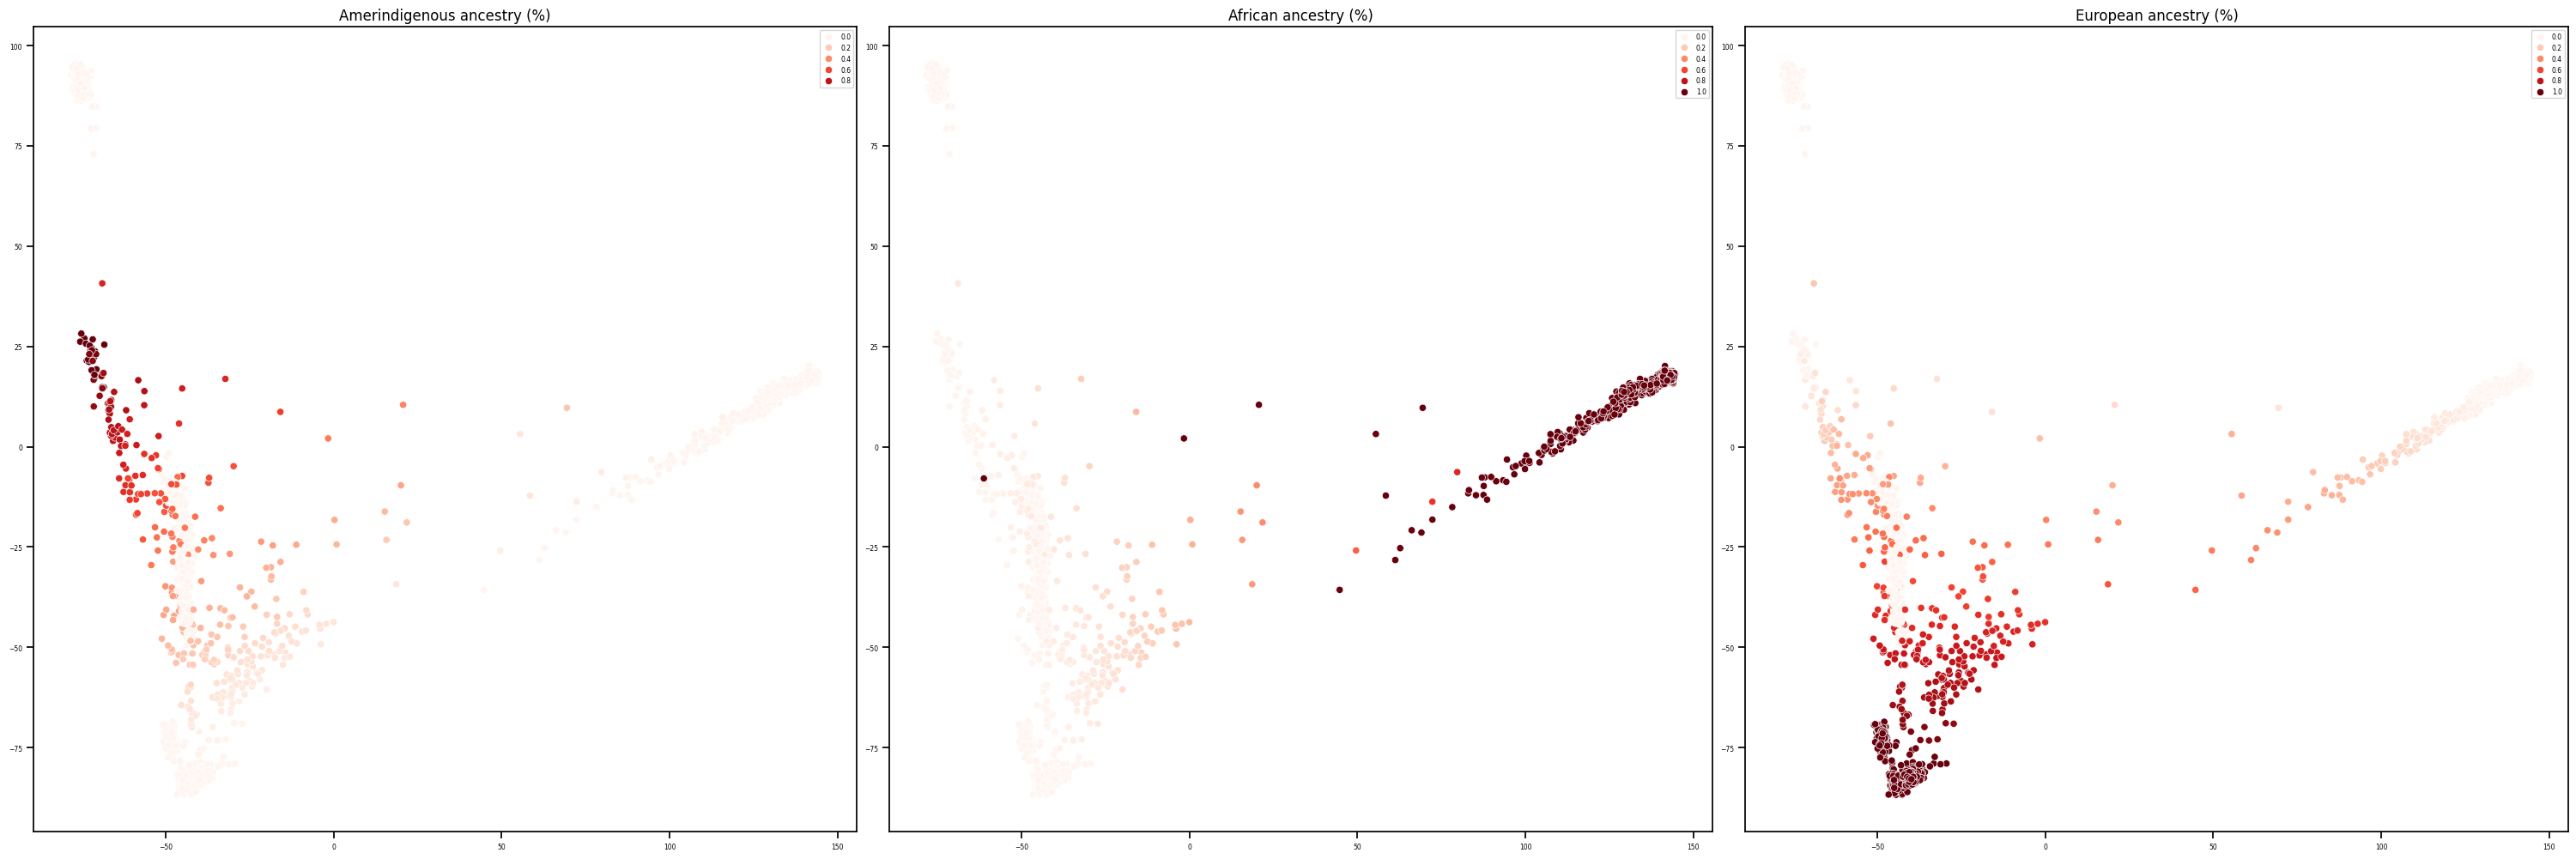

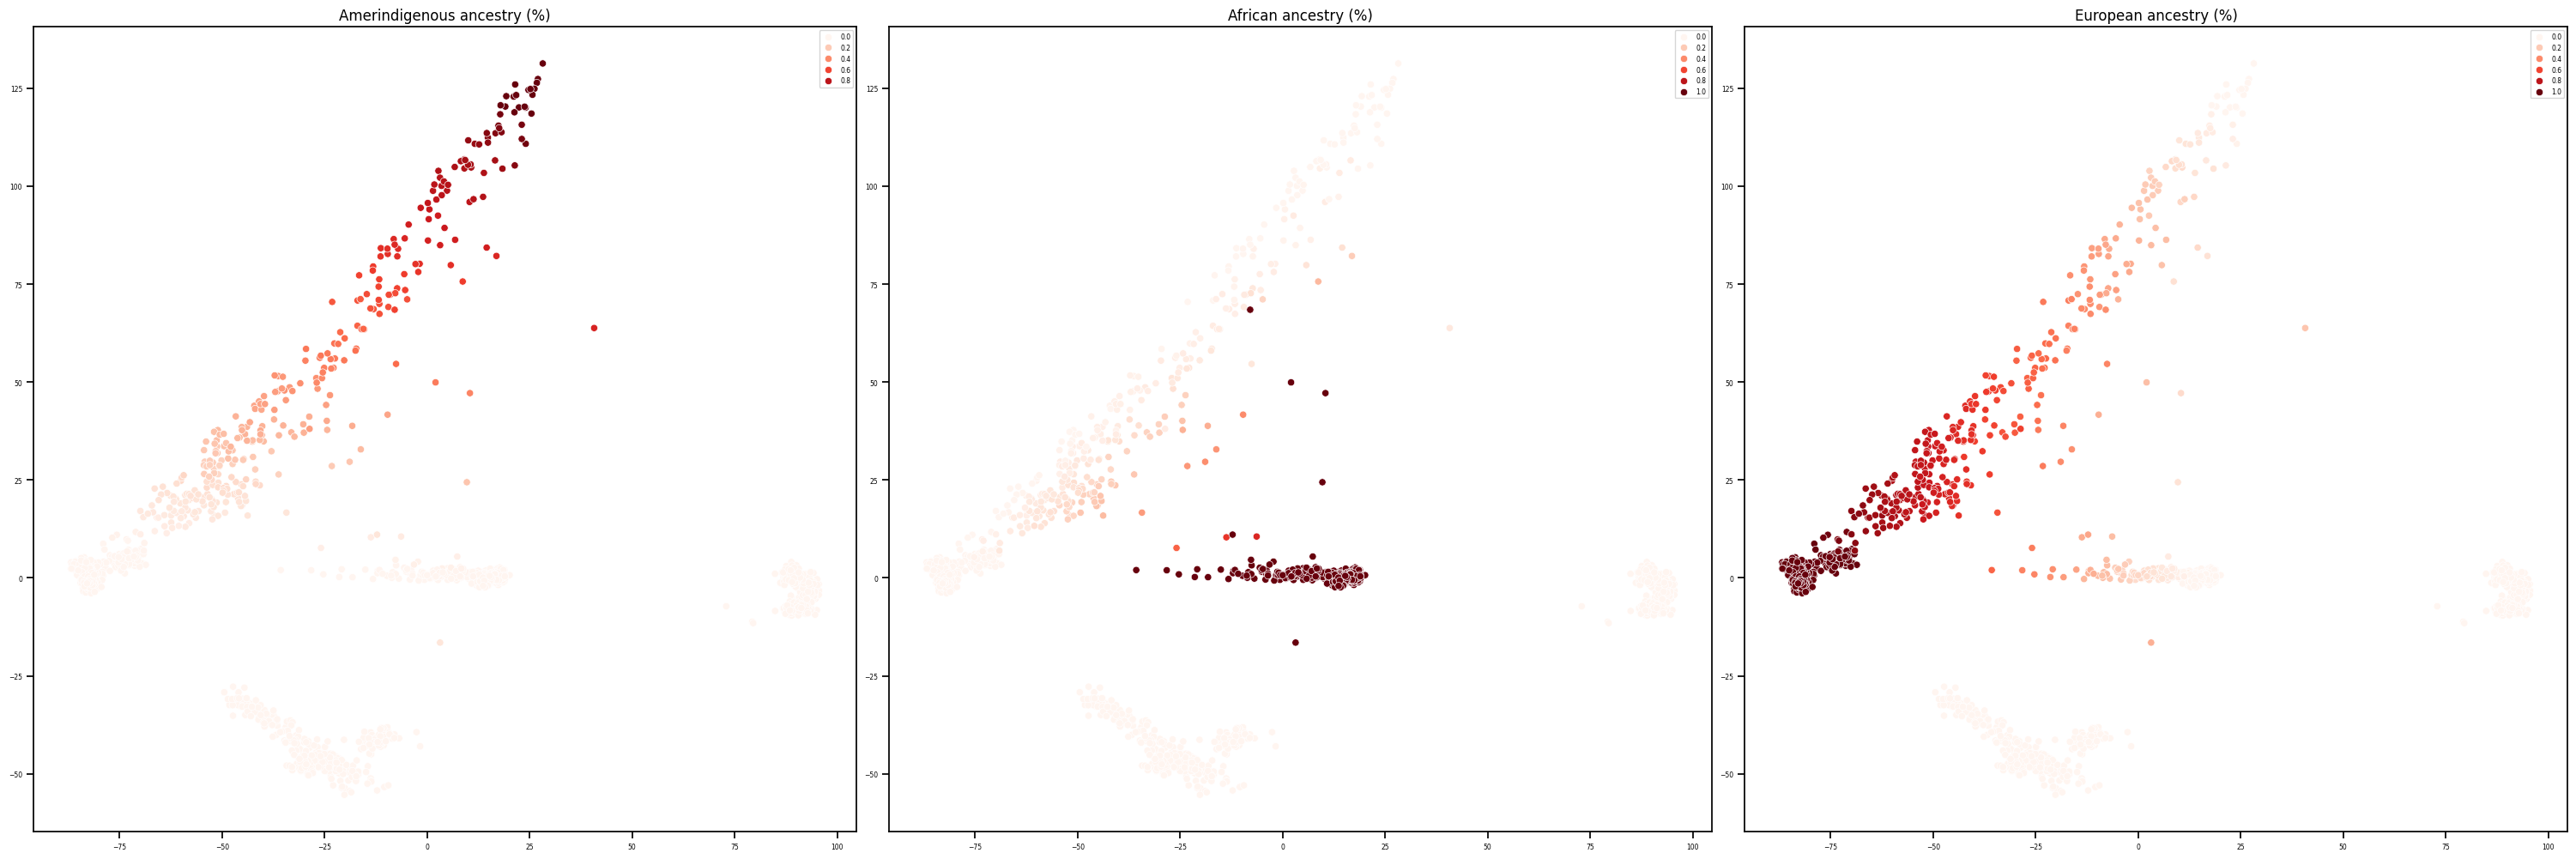

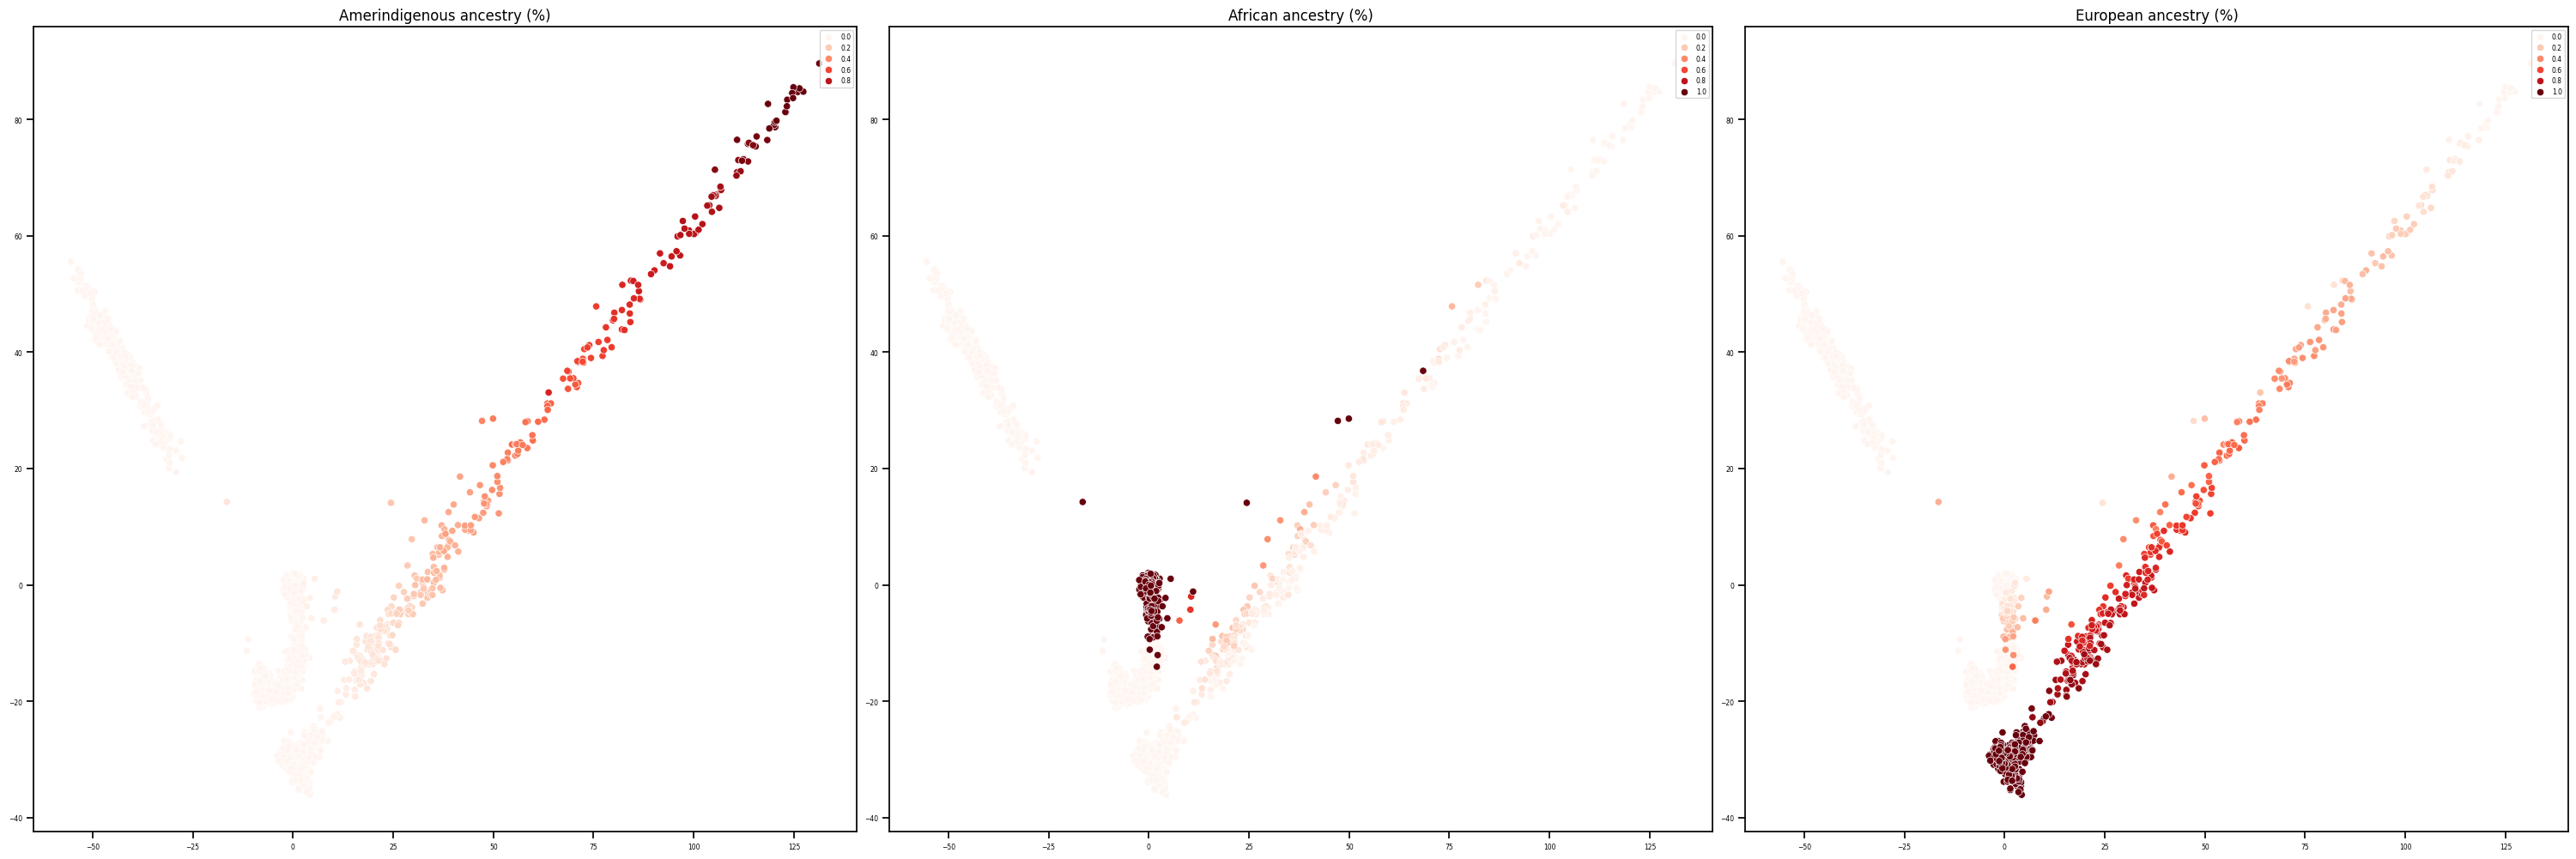

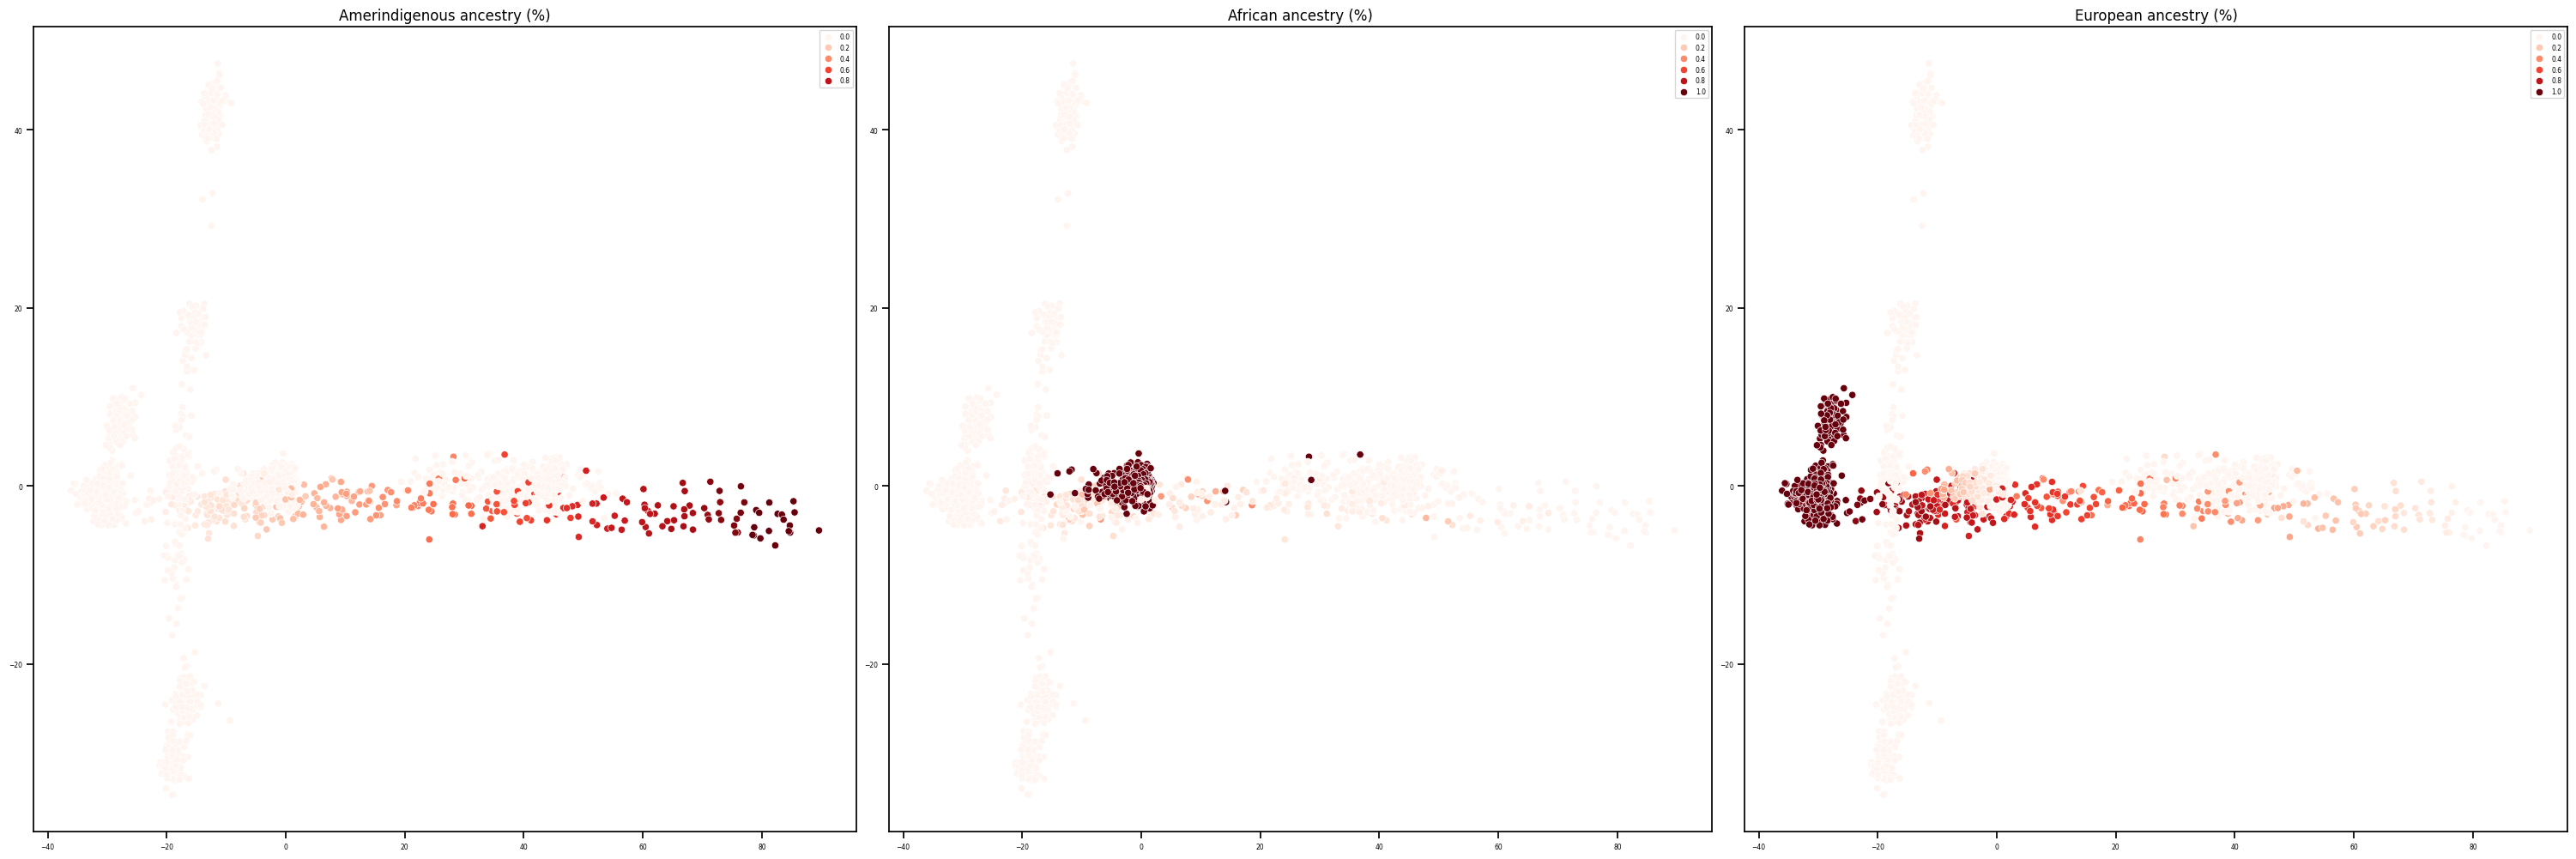

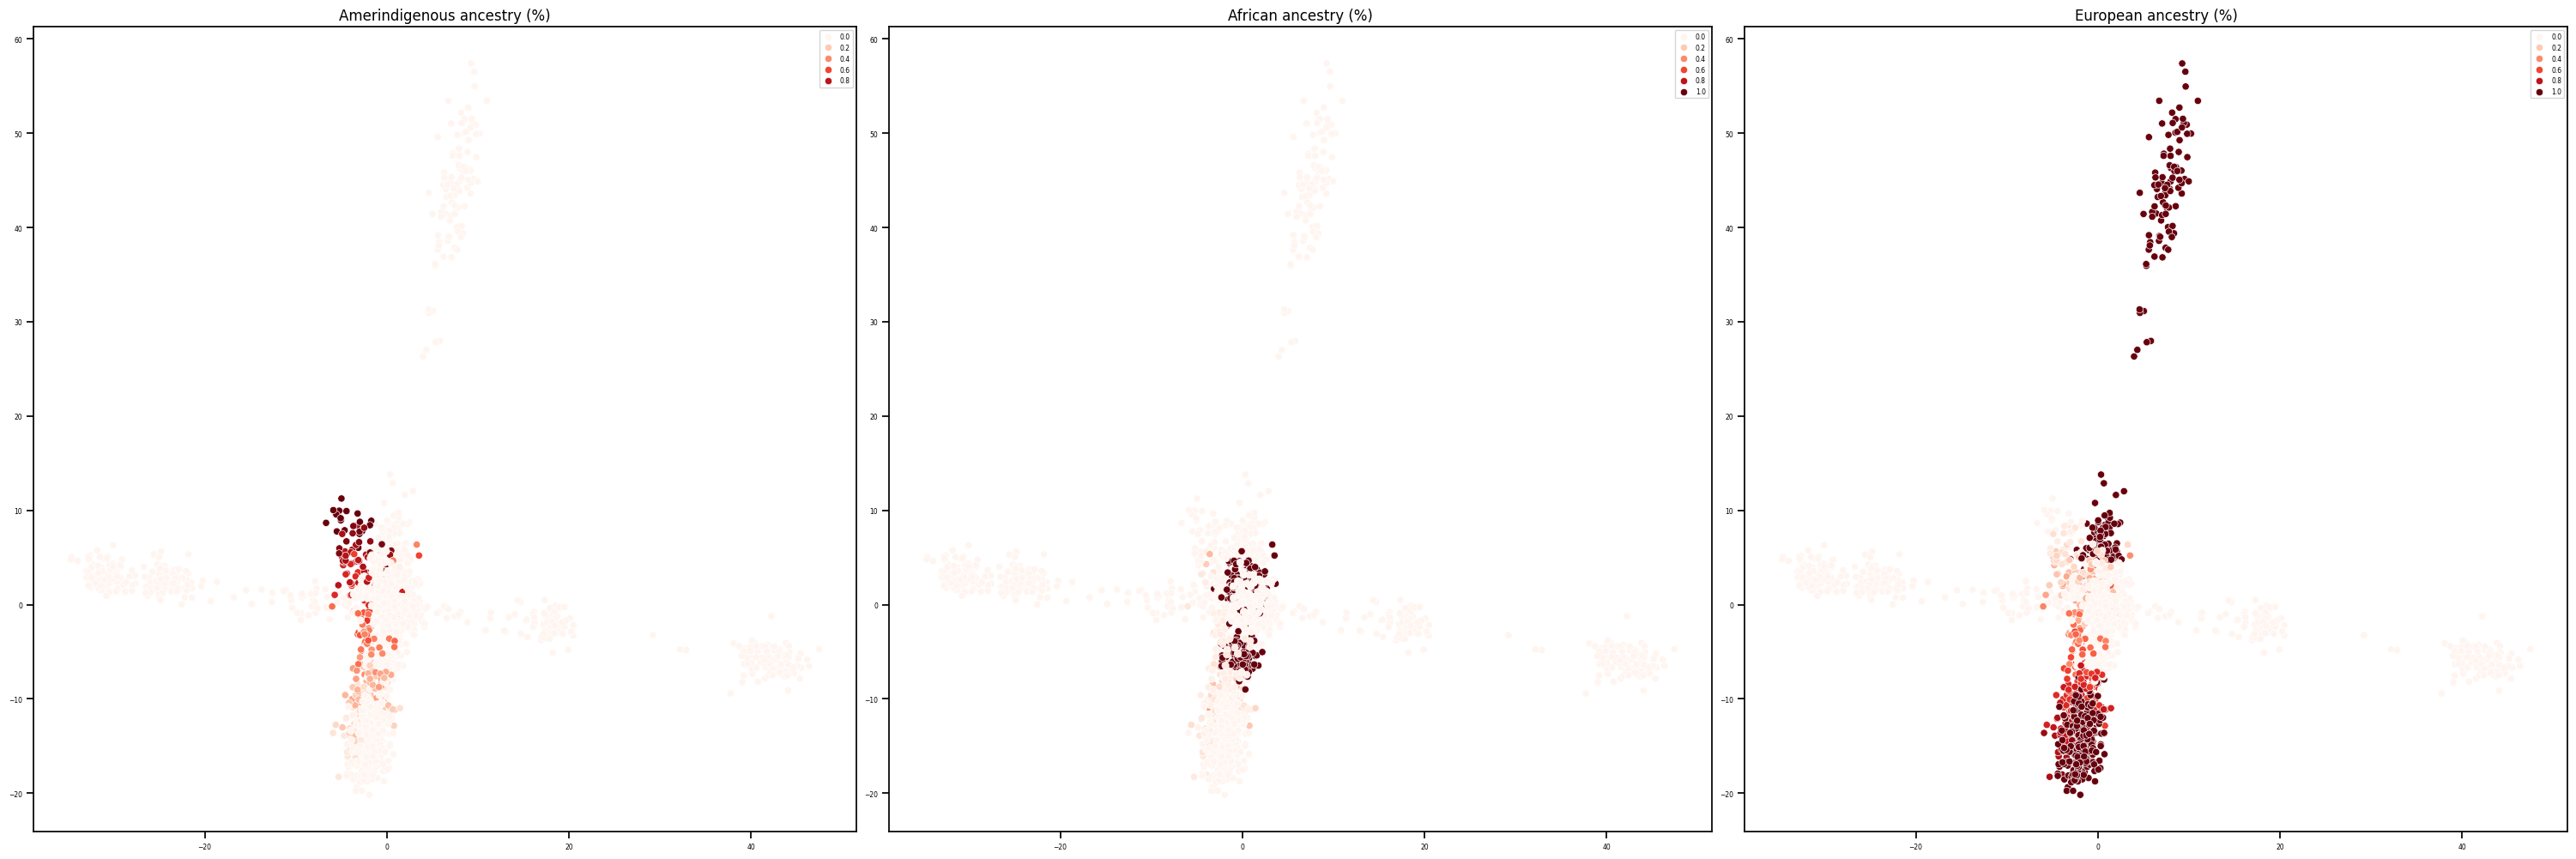

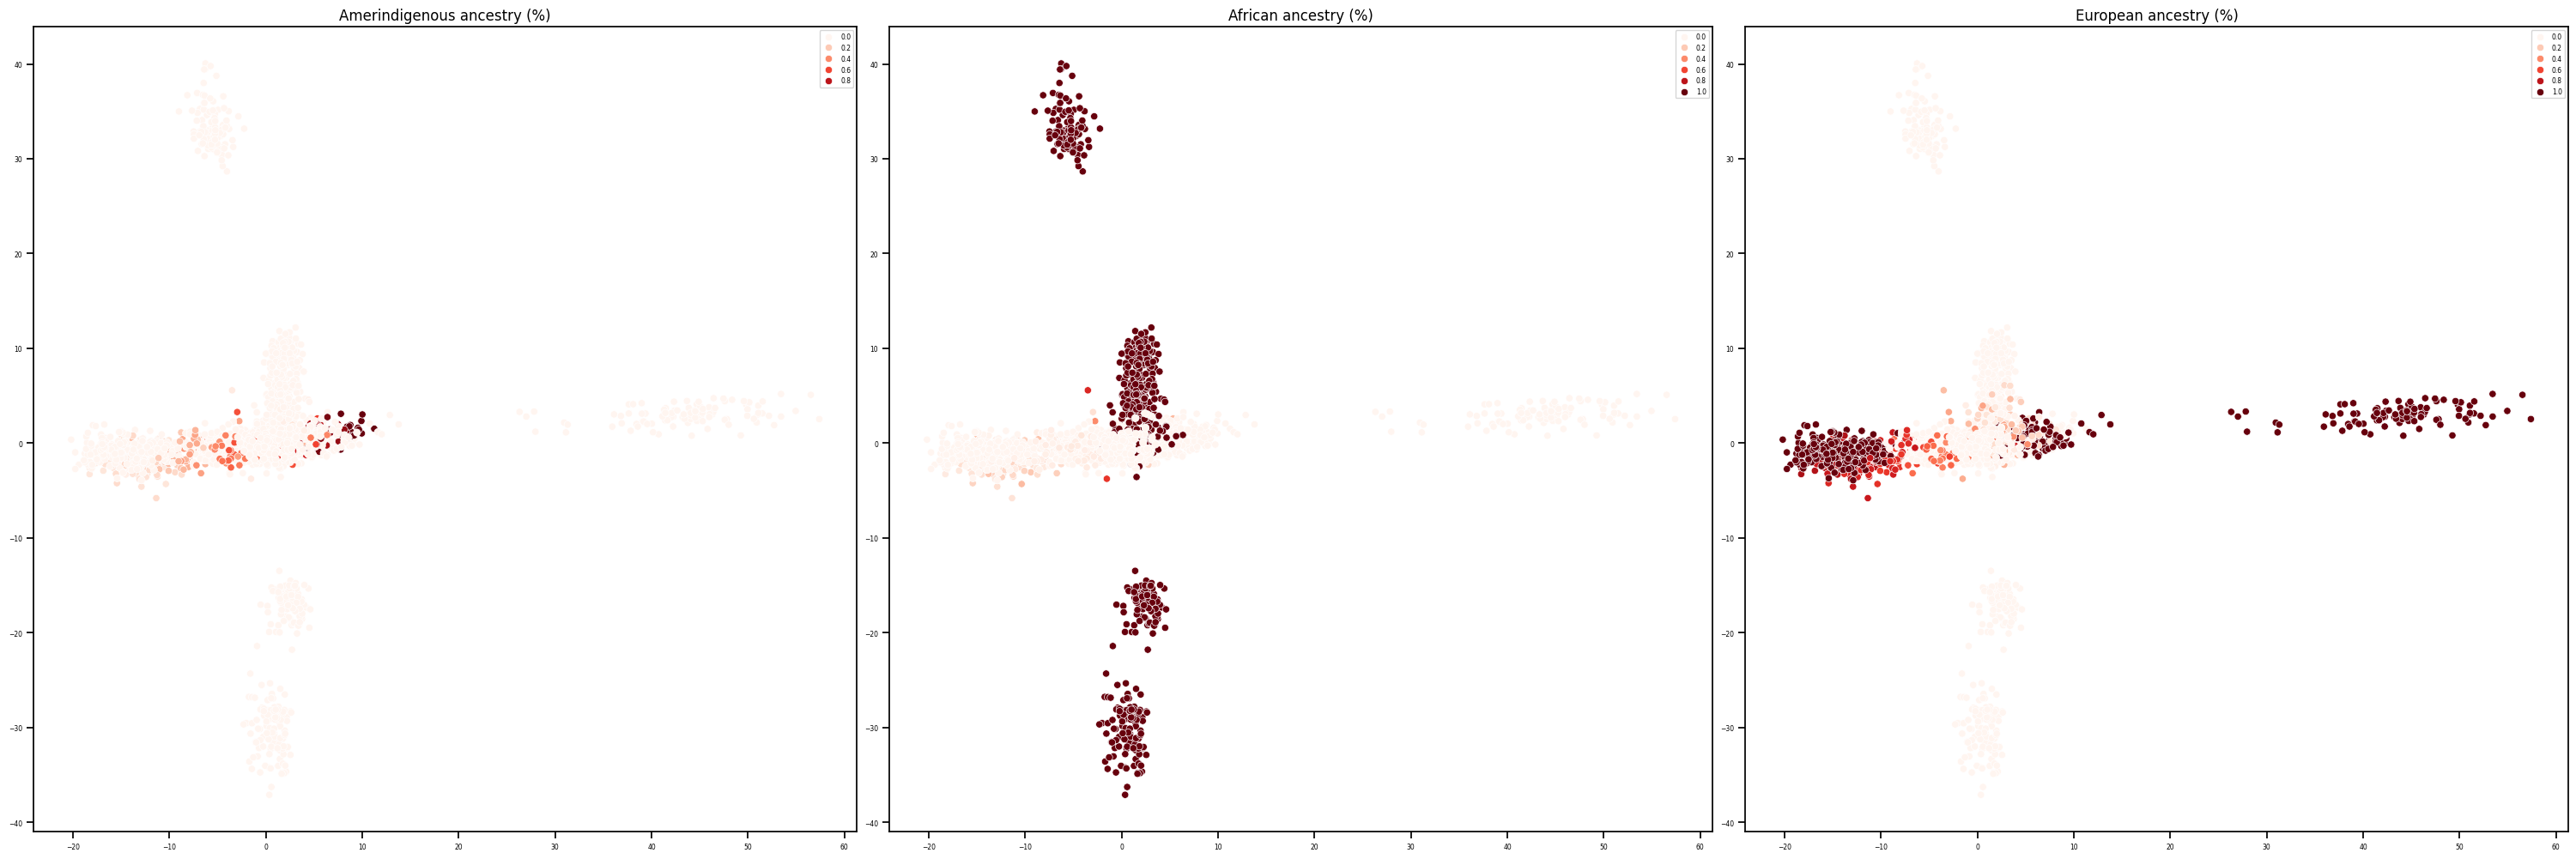

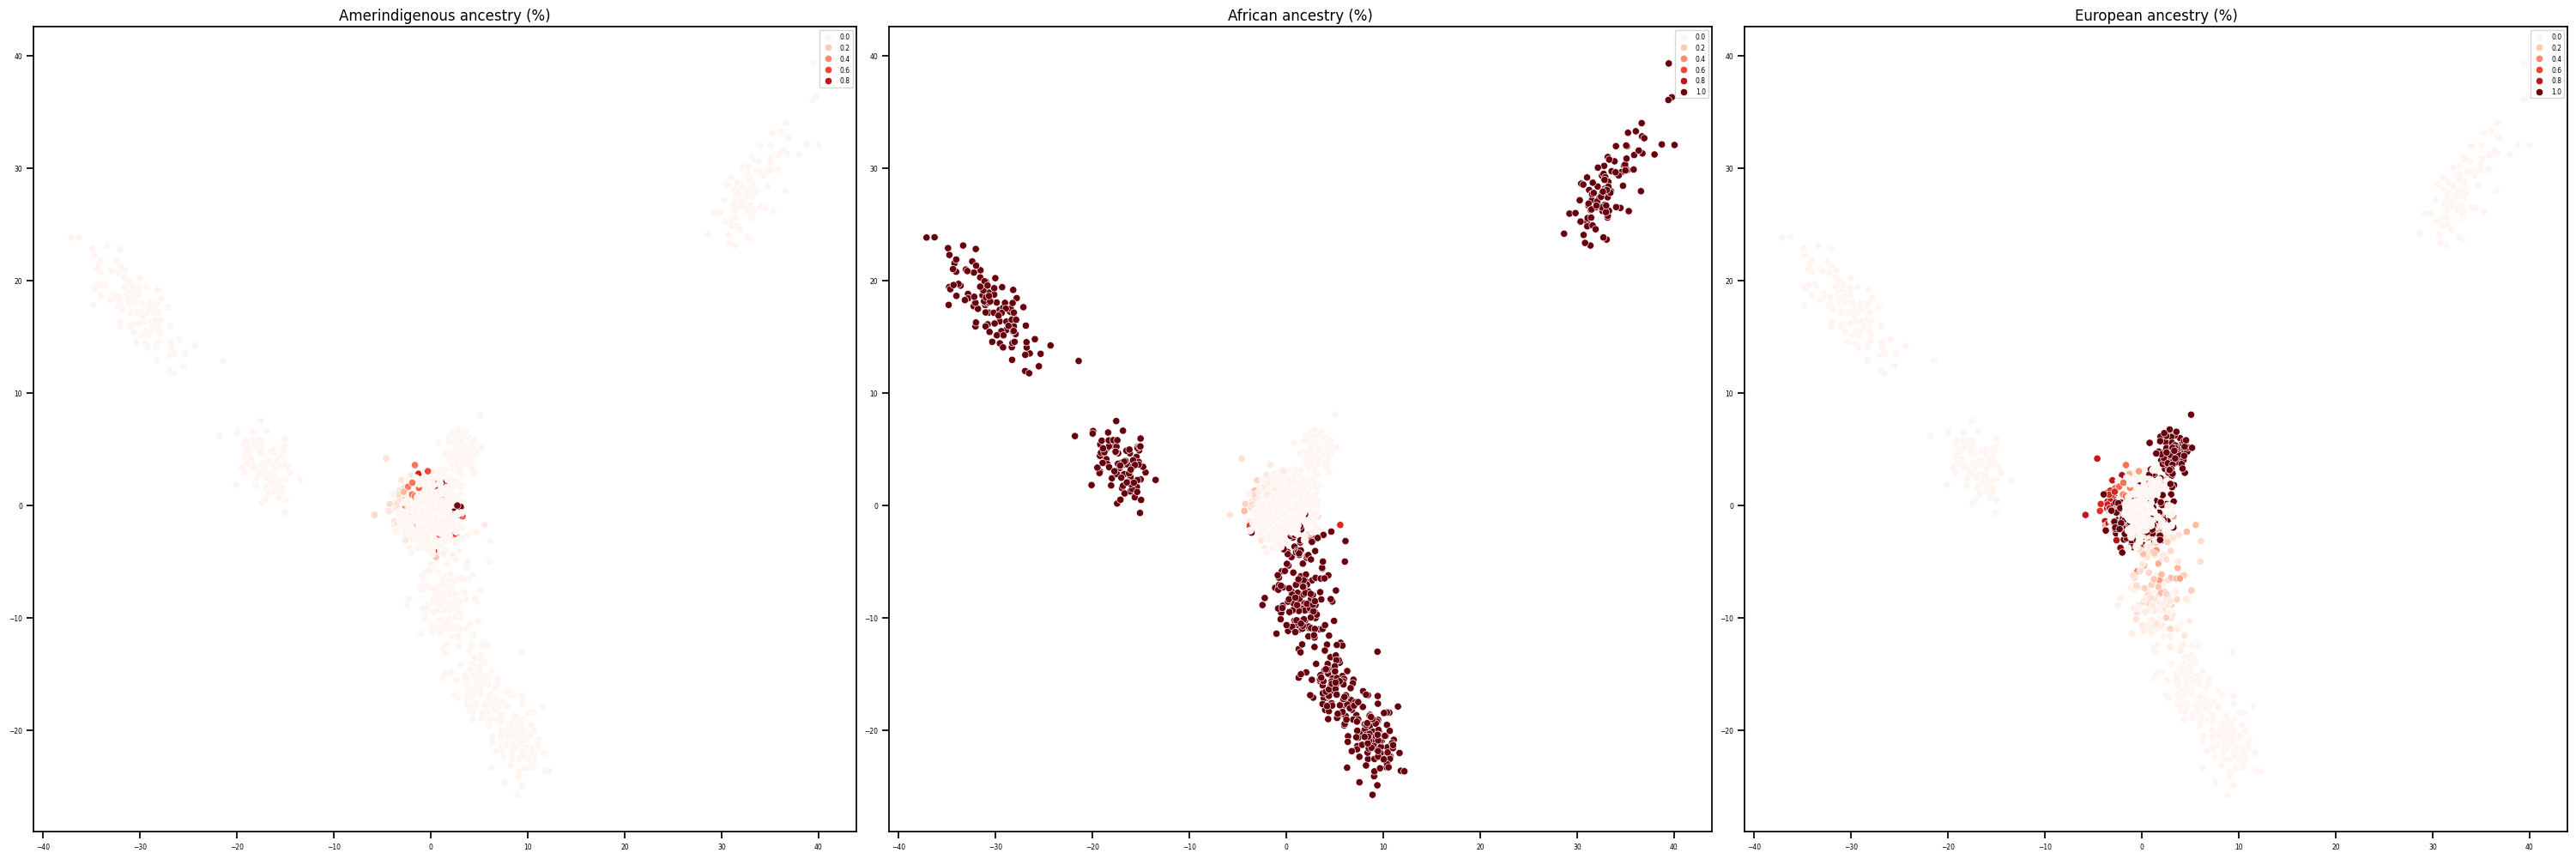

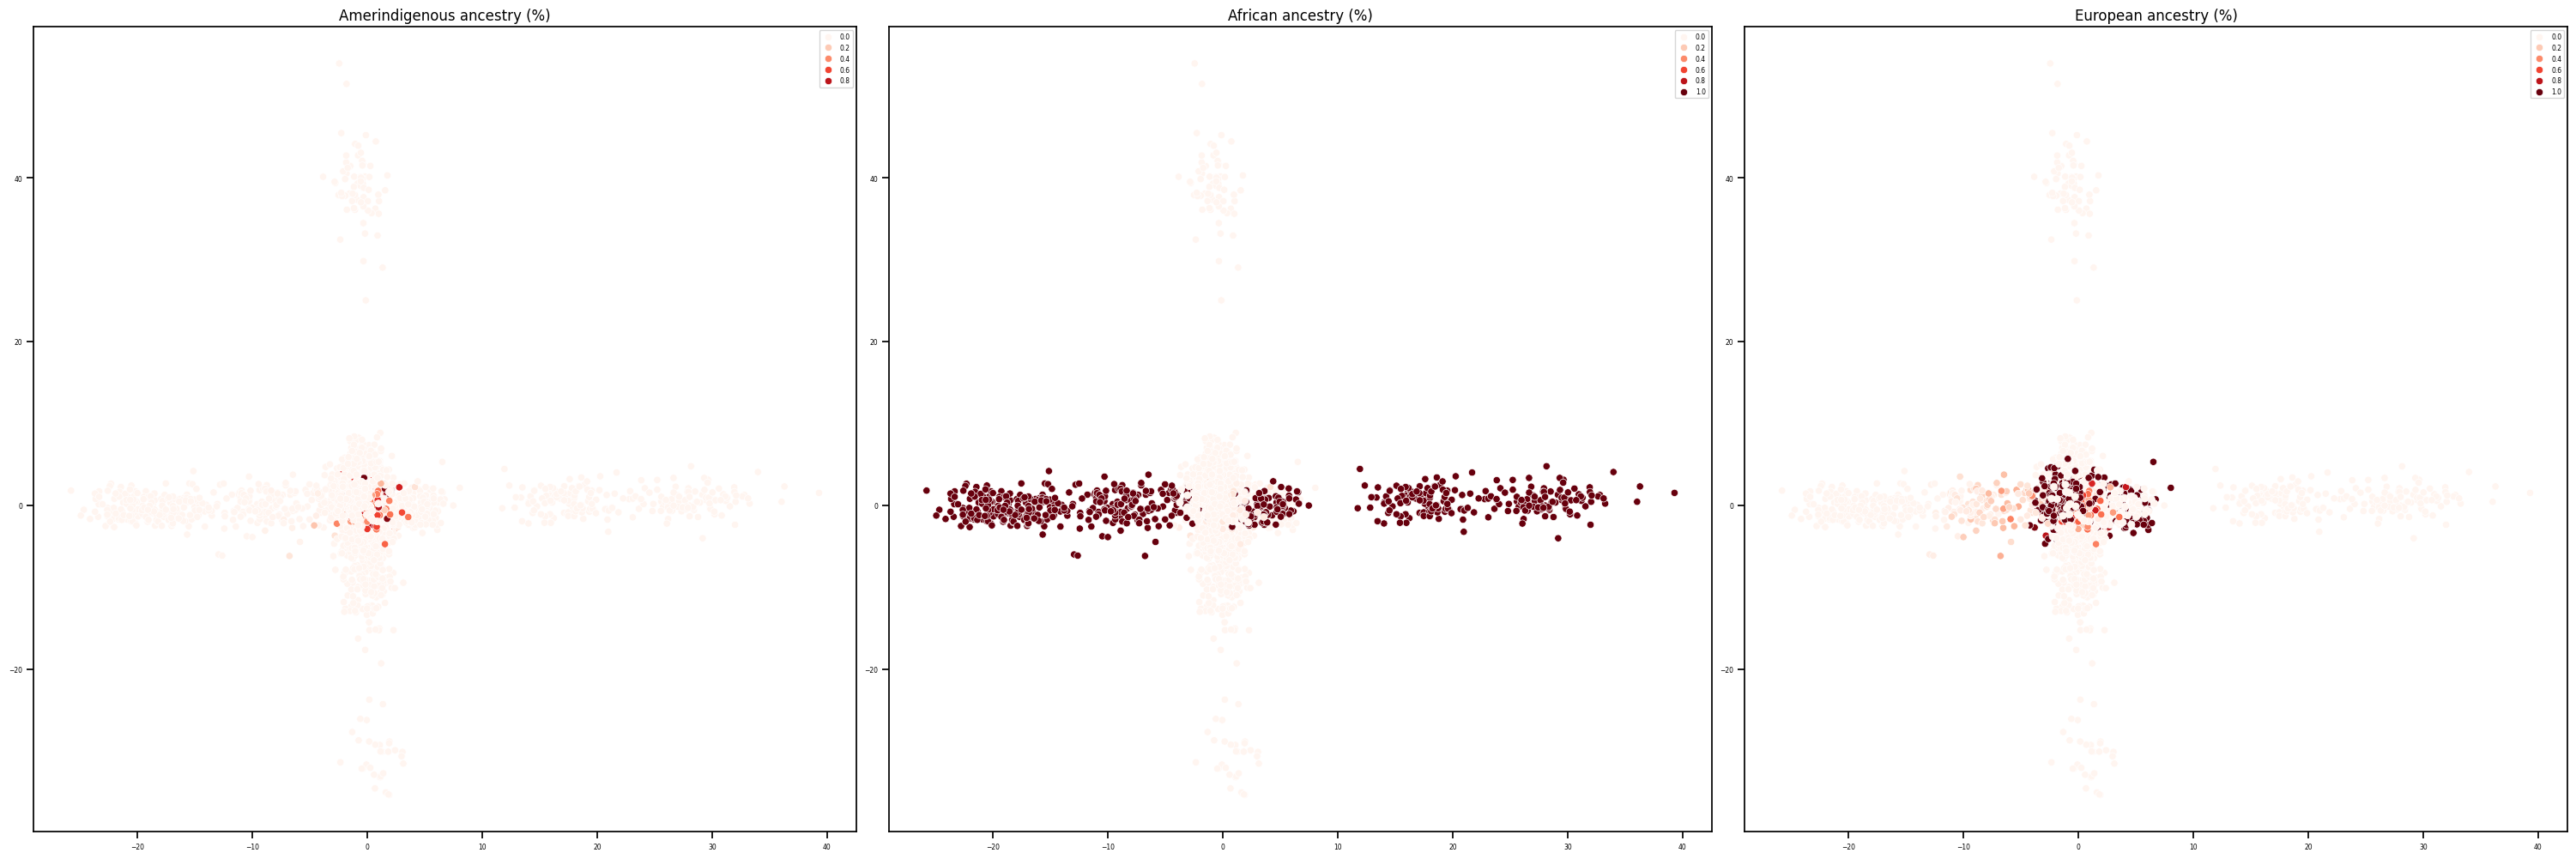

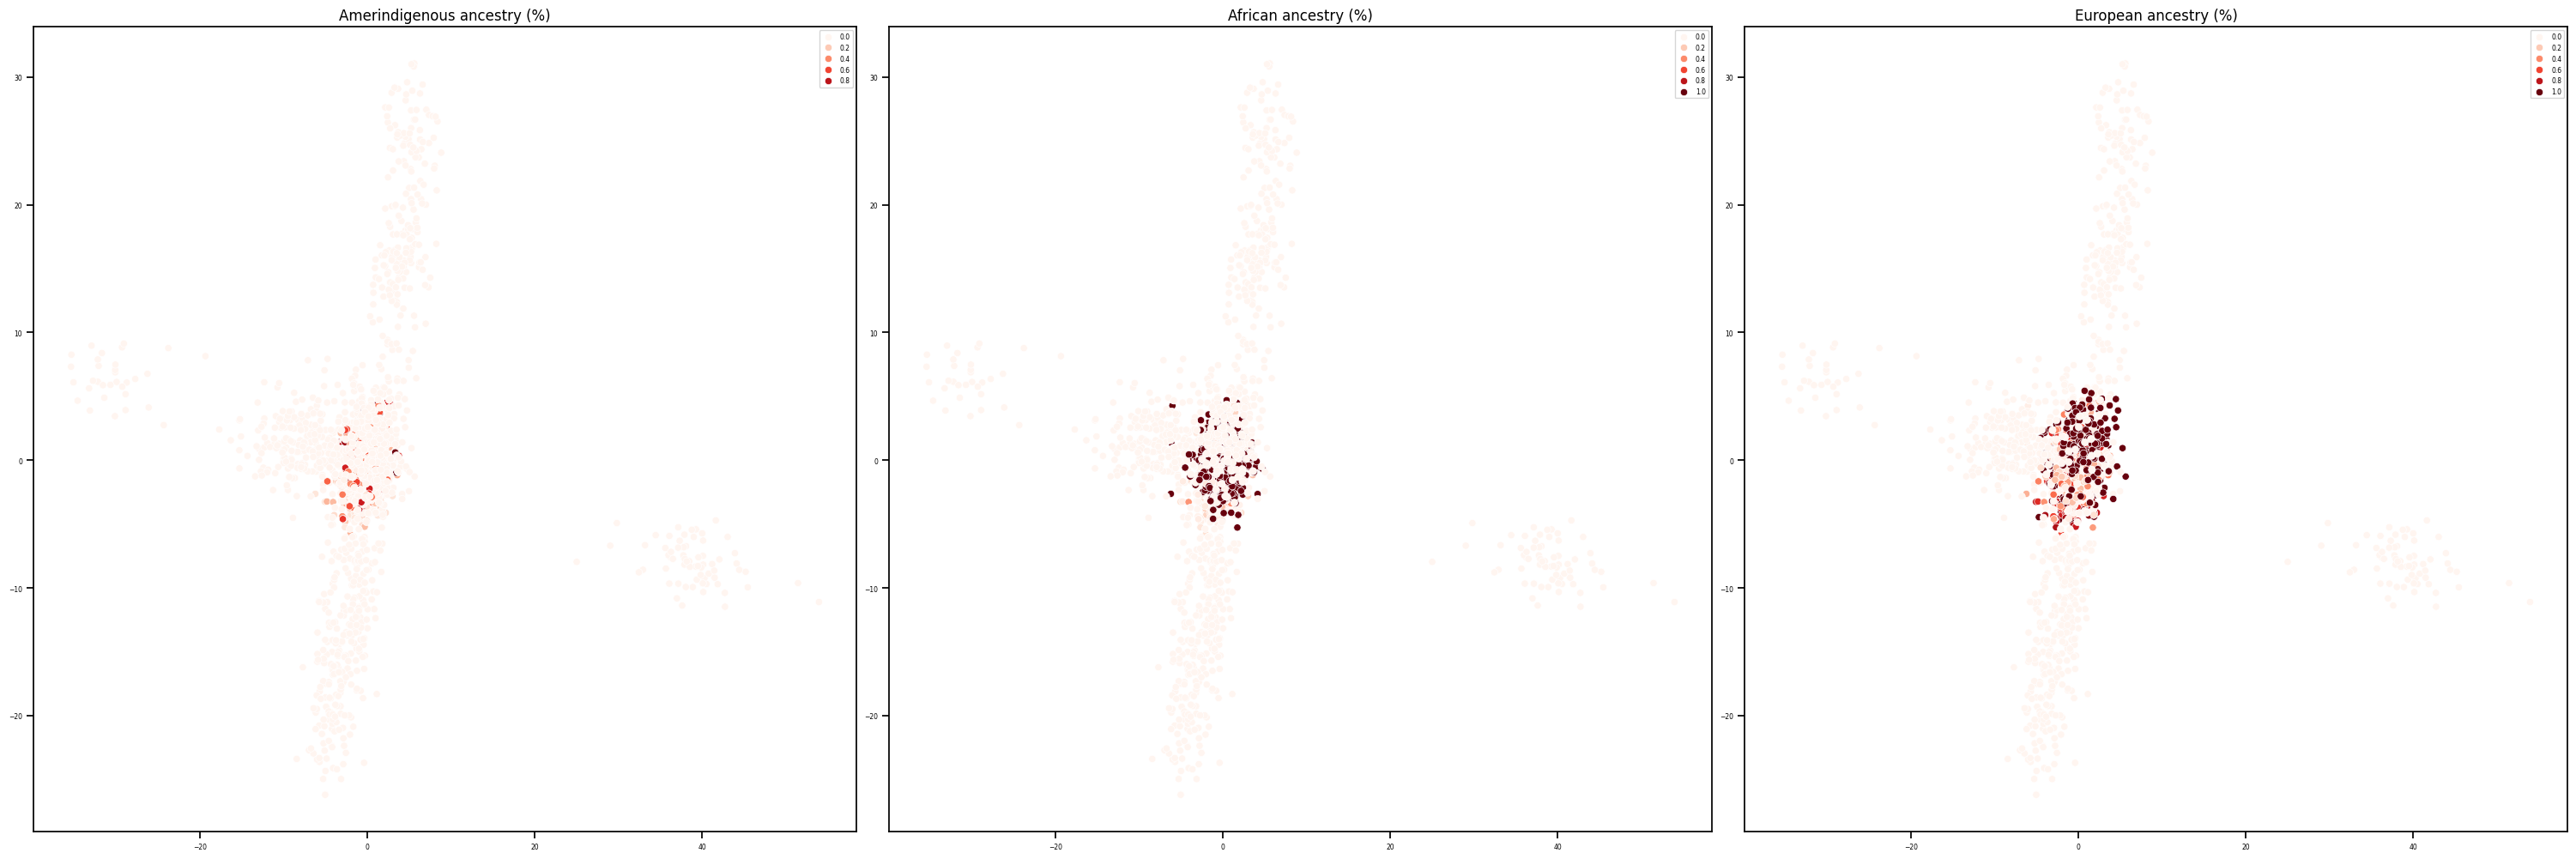

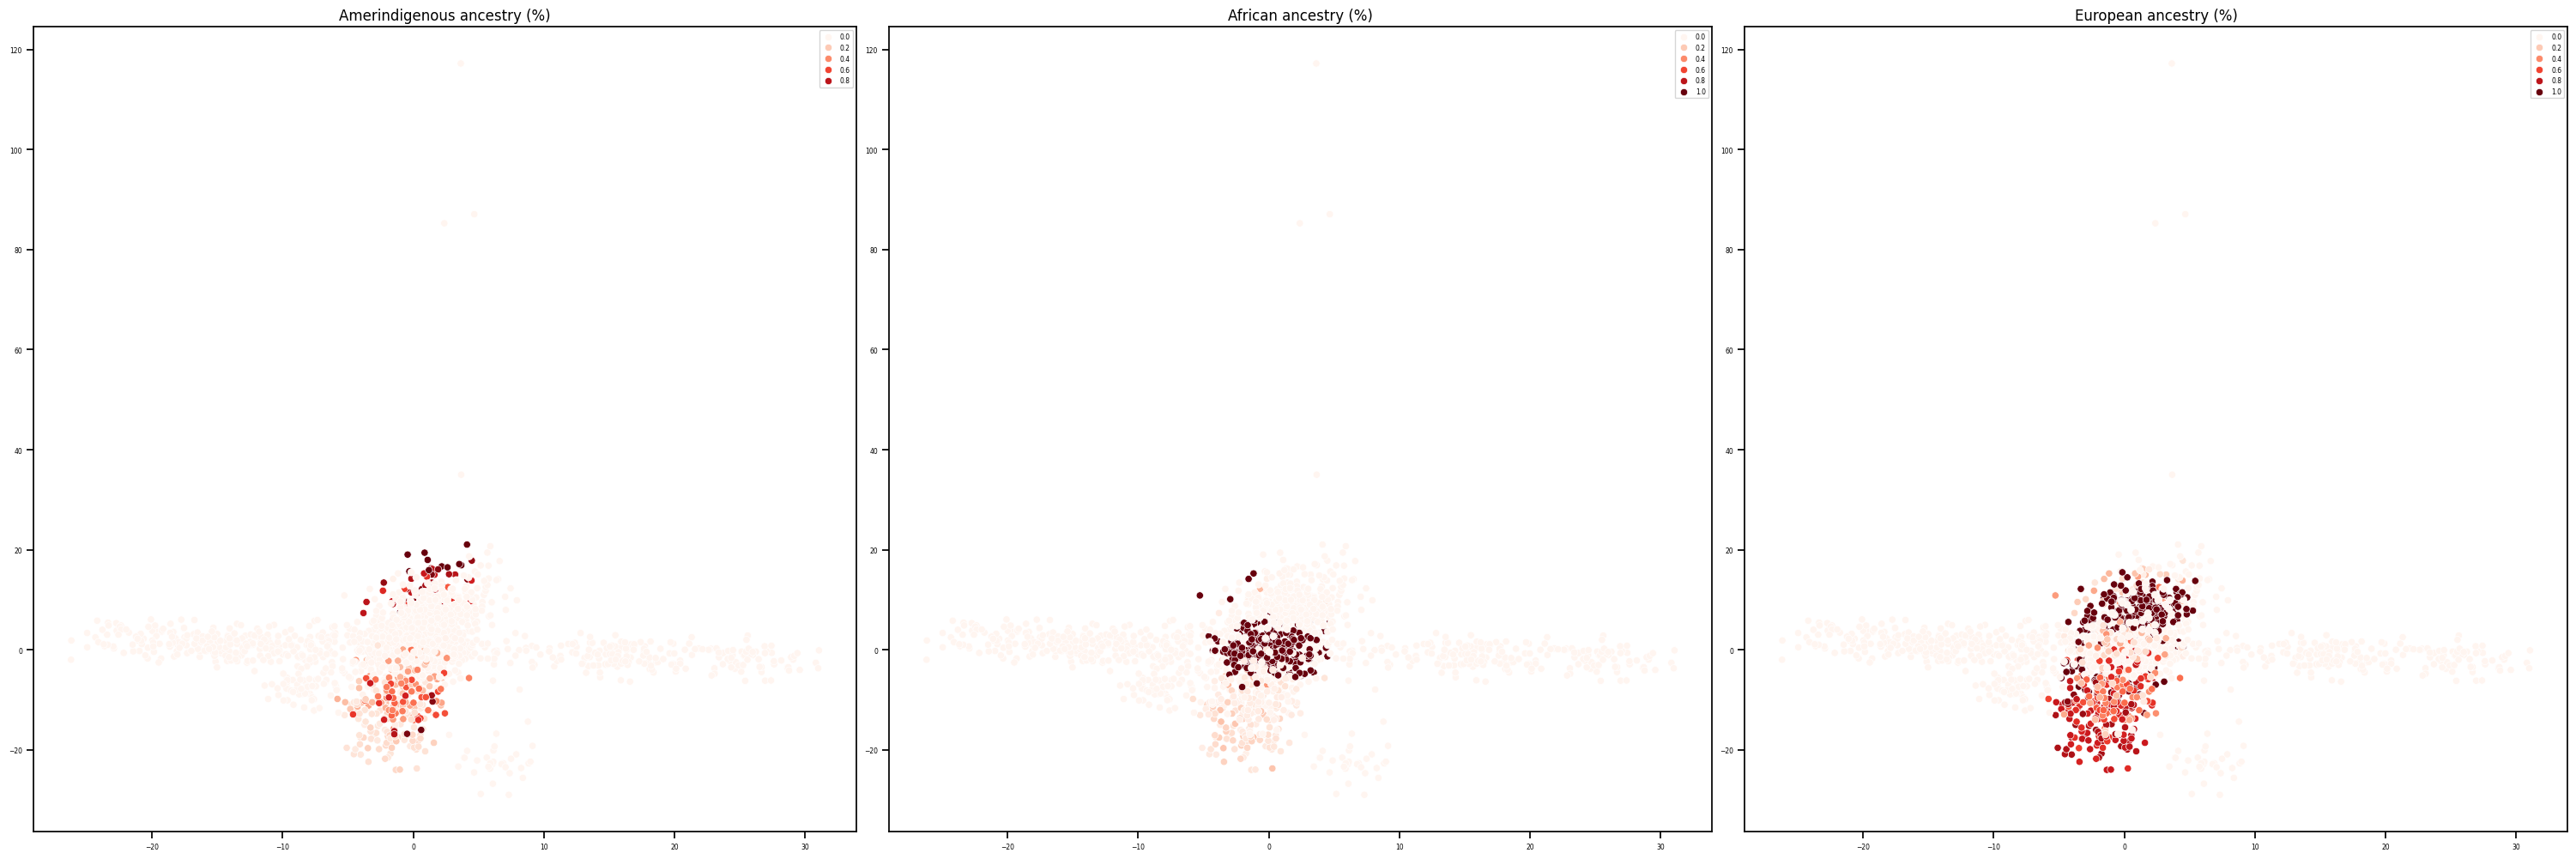

In [17]:
for comp in range(10):
    # initial 2D phate embedding
    fig, ax = plt.subplots(ncols=3, figsize=(30,10))

    sns.scatterplot(x=pca_input[:,comp],
                    y=pca_input[:,(comp+1)],
                    hue=admix_labels_custom2[:,1],
                    palette='Reds',
                    ax=ax[0])
    ax[0].set_title("Amerindigenous ancestry (%)", fontsize=12)

    sns.scatterplot(x=pca_input[:,comp],
                    y=pca_input[:,(comp+1)],
                    hue=admix_labels_custom2[:,0],
                    palette='Reds',
                    ax=ax[1])
    ax[1].set_title("African ancestry (%)", fontsize=12)
    sns.scatterplot(x=pca_input[:,comp],
                    y=pca_input[:,(comp+1)],
                    hue=admix_labels_custom2[:,2],
                    palette='Reds',
                    ax=ax[2])
    ax[2].set_title("European ancestry (%)", fontsize=12)
    plt.tight_layout()